In [1]:
from collections import Counter, OrderedDict, defaultdict
import copy
import glob
from itertools import izip
import itertools
import os
import subprocess
import tempfile

from IPython.core.display import HTML, Image
import itertools
import pandas as pd
from matplotlib import gridspec
from matplotlib_venn import venn2, venn3
import numpy as np
import scipy
import seaborn as sns

from clipper.src import CLIP_analysis
from clipper.src import get_genomic_regions
import flotilla
from gscripts import GO
from gscripts.general import dataviz
from gscripts.general import parsers
from gscripts.general import region_helpers
from gscripts.rnaseq.helpers import counts_to_rpkm

img_dir = "/nas3/gpratt/Dropbox/TAF15/Data/mouse_integration"


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
rbp_colors = {"fus": '#43A247',
             "FUS": '#43A247',
             'taf15': '#DB1D3D',
             'TAF15': '#DB1D3D',
             'tdp43': '#712878',
             'TDP43': '#712878',
             'fus_taf15': 'y',
             'taf15_tdp43': 'k',
             'R521G': 'c', 
             'T198C': 'c',
             'EWS' : 'g',
              'sALS': 'c',
             'ctrl': (0.90311419262605563, 0.54185316071790801, 0.76495195557089413),
              "spinalcord": 'r',
              'straitum': 'g',
              'wholebrain': 'b',
              }
rbp_names = {"spinalcord": 'Spinal Cord',
              'straitum': 'Straitum',
              'wholebrain': 'Whole Brain',
              'fus_taf15': 'FUS TAF15',
              'taf15_tdp43': 'TAF15 TDP43',
              "fus": 'FUS',
              'taf15': 'TAF15',
              'tdp43': 'TDP43',}

In [3]:
regions, all_regions = CLIP_analysis.regions_generator()

def move_name(interval):
    interval.name = interval[12]
    return interval

def gencode_to_ensembl(gene_list):
    for gene in gene_list:
        yield gene.split(".")[0]

In [4]:
!mkdir -p /nas3/gpratt/projects/fet_family/analysis/fet_family_v5/
!scp -q tscc-login.sdsc.edu:~/projects/fet_family/analysis/fet_family_v5/*.{final.out,metrics,rpkm} /nas3/gpratt/projects/fet_family/analysis/fet_family_v5/

#featureCounts -a /projects/ps-yeolab/genomes/mm9/gencode.vM1.annotation.gtf -o all_counts.txt -M *.bam -T 16
#!scp -q tscc-login.sdsc.edu:/home/gpratt/projects/fet_family/analysis/fet_family_v4/all_counts.txt .

'ENSMUSG00000056900.7'

In [375]:
rpkm[name_to_gene_id['Usp13']]

knockdown      cell_type    rep  analysis_group  exp                                        
Control Oligo  Striatum     25   1               MP25_Striatum_C2_control_oligo_RNAseq          4.483769
                            26   1               MP26_Striatum_C4_control_oligo_RNAseq          4.192659
                            27   1               MP27_Striatum_D2_control_oligo_RNAseq          4.240043
                            28   1               MP28_Striatum_D3_control_oligo_RNAseq          4.005472
EWS            Spinal Cord  1    4               EWSR_Sc_1                                      2.696061
                            2    4               EWSR_Sc_2                                      3.187585
                            3    4               EWSR_Sc_3                                      4.124544
                            4    4               EWSR_Sc_4                                      2.820804
HTT            Spinal Cord  1    4               ScHTT1            

In [5]:
analysis_dir = "/nas3/gpratt/projects/fet_family/analysis/fet_family_v5/"
fet_clip = parsers.rnaseq_metrics(analysis_dir)



fet_clip_filtered = fet_clip[[ "Input Reads",
                            #"Reads After Triming",
                            "Uniquely Mapped Reads",
                            "Uniquely mapped reads %",
                            ]]

HTML(fet_clip_filtered.to_html(formatters={"Input Reads" : parsers.commas,
                                     "Reads After Triming" : parsers.commas,
                                     "Reads after Quality Filtering" : parsers.commas,
                                     "Uniquely Mapped Reads" : parsers.commas,
                                     } ))

In [6]:
featureCount_metadata = pd.read_csv("/nas3/gpratt/Dropbox/TAF15/unix_mouse_fet_data_locations_and_annitations.csv")
null_reps = featureCount_metadata[featureCount_metadata['Biological Replicate'].isnull()]
not_null_reps = featureCount_metadata[~featureCount_metadata['Biological Replicate'].isnull()]

In [7]:
results = []
for exp in set(not_null_reps['Biological Replicate']):
    results.append(exp + ".bam")
    
for exp in null_reps.Location.apply(lambda x: os.path.basename(x).split(".")[0] + ".polyATrim.adapterTrim.rmRep.sorted.rg.bam"):
    results.append(exp)

In [8]:
#These are the things to count in featureCounts
#" ".join(results)

In [9]:
!scp tscc-login.sdsc.edu:/home/gpratt/projects/fet_family/analysis/featurecounts_bams/*.txt /nas3/gpratt/projects/fet_family/analysis/fet_family_v5/


all_counts_0.txt                              100%   16MB  16.5MB/s   00:01    
all_counts.txt                                100%   16MB  16.4MB/s   00:01    


In [10]:
metadata = pd.read_csv("/nas3/gpratt/Dropbox/TAF15/unix_mouse_fet_data_locations_and_annitations.csv")
metadata = metadata[metadata.geo_name != "not_submitted"]
null_bioreps = metadata[metadata['Biological Replicate'].isnull()]
metadata.loc[null_bioreps.index,'Biological Replicate'] = null_bioreps.Location.apply(lambda x: os.path.basename(x).split(".")[0]).values
metadata['file_name'] = metadata.Location.apply(os.path.basename)
metadata['file_name'] = metadata.file_name.apply(lambda x: x.split(".")[0])
technicalrep_info = metadata.copy()
technicalrep_info.index = technicalrep_info.file_name

biorep_info = metadata.groupby('Biological Replicate').first()

#old all counts
#all_counts = pd.read_table("all_counts.txt", index_col=0, skiprows=1)
all_counts = pd.read_table("/nas3/gpratt/projects/fet_family/analysis/fet_family_v5/all_counts.txt", index_col=0, skiprows=1)
all_counts.columns = [item.split(".")[0] for item in all_counts.columns]


rpkm = counts_to_rpkm(all_counts)
rpkm = rpkm.T
rpkm = rpkm.ix[biorep_info.index]
flotilla_rpkm = rpkm.copy()

result = []
for index in rpkm.index:
    exp_info = biorep_info.ix[index] 
    result.append([exp_info['rbp'], exp_info['Cell Type'], exp_info['bio_rep'], exp_info['analysis_group'], biorep_info.ix[index].name])
rpkm.index = pd.MultiIndex.from_tuples(result, names=['knockdown', 'cell_type', 'rep', 'analysis_group', 'exp'])
rpkm = rpkm.sortlevel()

In [296]:
rpkm.ix[['Control Oligo', 'TDP43']]

Geneid                                                                                  ENSMUSG00000090025.1  \
knockdown     cell_type rep analysis_group exp                                                                 
Control Oligo Striatum  25  1              MP25_Striatum_C2_control_oligo_RNAseq                    0.000000   
                        26  1              MP26_Striatum_C4_control_oligo_RNAseq                    0.000000   
                        27  1              MP27_Striatum_D2_control_oligo_RNAseq                    0.000000   
                        28  1              MP28_Striatum_D3_control_oligo_RNAseq                    0.000000   
TDP43         Striatum  15  1              MP15_Striatum_C1_TDP43_knockdown_81%_RNAseq              0.057421   
                        16  1              MP16_Striatum_C2_TDP43_knockdown_81%_RNAseq              0.000000   
                        29  1              MP29_Striatum_H2_TDP43_knockdown_78%_RNAseq              0.000000   
                        30  1              MP30_Striatum_K2_TDP43_knockdown_80%_RNAseq              0.071035   

Geneid                                                                                  ENSMUSG00000064842.1  \
knockdown     cell_type rep analysis_group exp                                                                 
Control Oligo Striatum  25  1              MP25_Striatum_C2_control_oligo_RNAseq                           0   
                        26  1              MP26_Striatum_C4_control_oligo_RNAseq                           0   
                        27  1              MP27_Striatum_D2_control_oligo_RNAseq                           0   
                        28  1              MP28_Striatum_D3_control_oligo_RNAseq                           0   
TDP43         Striatum  15  1              MP15_Striatum_C1_TDP43_knockdown_81%_RNAseq                     0   
                        16  1              MP16_Striatum_C2_TDP43_knockdown_81%_RNAseq                     0   
                        29  1              MP29_Striatum_H2_TDP43_knockdown_78%_RNAseq                     0   
                        30  1              MP30_Striatum_K2_TDP43_knockdown_80%_RNAseq                     0   

Geneid                                                                                  ENSMUSG00000051951.5  \
knockdown     cell_type rep analysis_group exp                                                                 
Control Oligo Striatum  25  1              MP25_Striatum_C2_control_oligo_RNAseq                    5.873835   
                        26  1              MP26_Striatum_C4_control_oligo_RNAseq                    5.492810   
                        27  1              MP27_Striatum_D2_control_oligo_RNAseq                    5.671372   
                        28  1              MP28_Striatum_D3_control_oligo_RNAseq                    4.414823   
TDP43         Striatum  15  1              MP15_Striatum_C1_TDP43_knockdown_81%_RNAseq              2.690800   
                        16  1              MP16_Striatum_C2_TDP43_knockdown_81%_RNAseq              1.464652   
                        29  1              MP29_Striatum_H2_TDP43_knockdown_78%_RNAseq              4.852427   
                        30  1              MP30_Striatum_K2_TDP43_knockdown_80%_RNAseq              4.420849   

Geneid                                                                                  ENSMUSG00000089699.1  \
knockdown     cell_type rep analysis_group exp                                                                 
Control Oligo Striatum  25  1              MP25_Striatum_C2_control_oligo_RNAseq                    0.000000   
                        26  1              MP26_Striatum_C4_control_oligo_RNAseq                    0.000000   
                        27  1              MP27_Striatum_D2_control_oligo_RNAseq                    0.111488   
                        28  1              MP28_Striatum_D3_control_oligo_RNA

In [295]:
rpkm.ix[['Control Oligo', 'TDP43']].T.to_csv("/nas3/gpratt/Dropbox/TAF15/tdp43_rnaseq_and_control.csv")

In [11]:
annotated_qc = pd.merge(fet_clip, metadata, left_index=True, right_on="file_name")
taf15_only_qc = annotated_qc[annotated_qc.analysis_group.isin([2, 3,4]) & annotated_qc.rbp.isin(['TAF15', 'HTT'])]
print taf15_only_qc['Uniquely Mapped Reads'].mean()
print np.mean([float(item[:-1]) for item in taf15_only_qc['Uniquely mapped reads %']])

24817206.6111
85.6438888889


In [12]:
# result = []
# fet_clip_filtered = fet_clip_filtered.ix[technicalrep_info.index]
# for index in fet_clip_filtered.index:
#     exp_info = technicalrep_info.ix[index] 
#     result.append([exp_info['rbp'], exp_info['Cell Type'], exp_info['bio_rep'], exp_info['analysis_group'], technicalrep_info.ix[index].name])
# fet_clip_filtered.index = pd.MultiIndex.from_tuples(result, names=['knockdown', 'cell_type', 'rep', 'analysis_group', 'exp'])
# fet_clip_filtered = fet_clip_filtered.sortlevel()

In [13]:
flotilla_metadata = metadata.groupby('Biological Replicate').first()
flotilla_metadata['phenotype'] = flotilla_metadata.rbp

#All QC

22 6


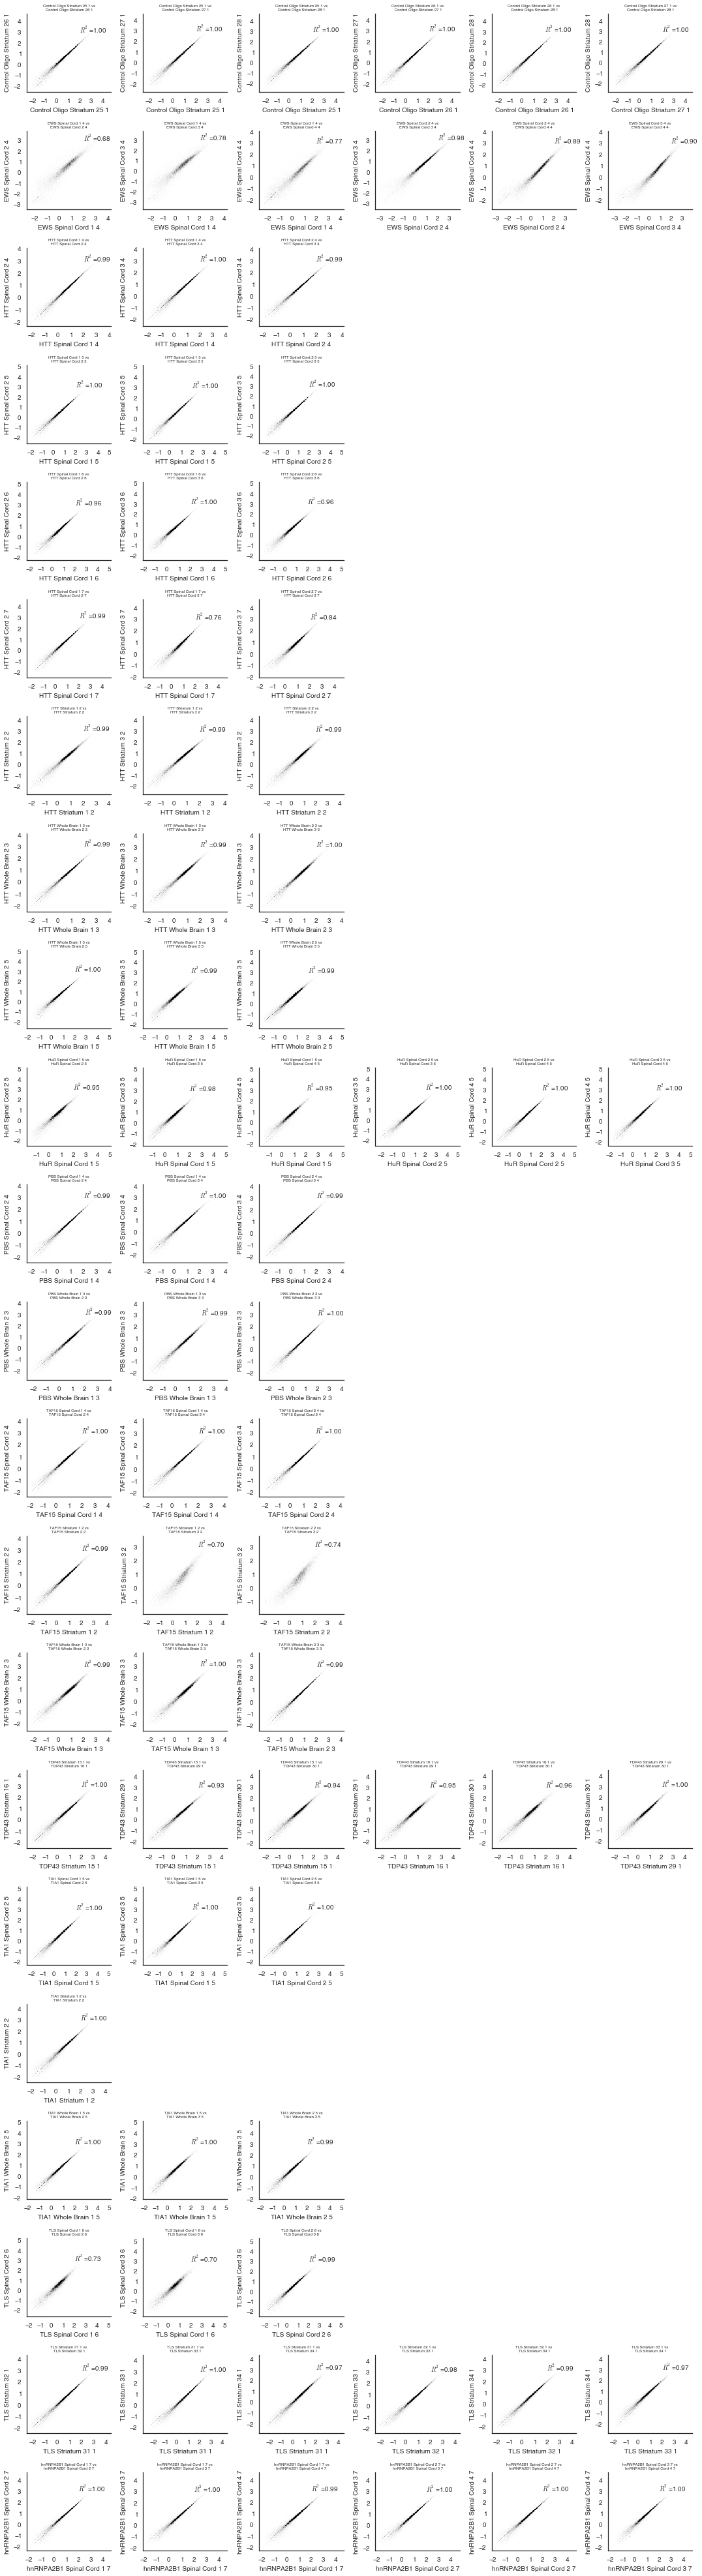

In [14]:
max_combinations = np.max(rpkm.groupby(level=("knockdown", "cell_type", "analysis_group")).count().values)
num_rows = len(list(rpkm.groupby(level=("knockdown", "cell_type", "analysis_group"))))
num_cols = len(list(itertools.combinations(range(max_combinations), 2)))
print num_rows, num_cols 
with dataviz.Figure(os.path.join(img_dir, "replicate_plotting.svg"), figsize=(2.5 * num_cols,2.5*num_rows)) as fig:
    gs = gridspec.GridSpec(num_rows, num_cols)
    for x, (name, group) in enumerate(rpkm.groupby(level=("knockdown", "cell_type", "analysis_group"))):
        for y, (name1, name2) in enumerate(itertools.combinations(group.index, 2)):
            ax = fig.add_subplot(gs[x,y])
            series1 = rpkm.ix[name1]
            series2 = rpkm.ix[name2]

            dataviz.loglog_hist2d(series1, series2, ax=ax)
            sns.despine(ax=ax)
            name1 = " ".join(map(str, name1[:-1]))
            name2 = " ".join(map(str, name2[:-1]))
            
            ax.set_xlabel(name1, fontsize=10)
            ax.set_ylabel(name2, fontsize=10)
            r2 = scipy.stats.linregress(series1, series2)[2]
            ax.text(2, 3, "$R^2$={:.2f}".format(r2))
            ax.set_title("{} vs\n{}".format(name1, name2), fontsize=6)
            [tick.set_fontsize(10) for tick in ax.get_xticklabels()]
            [tick.set_fontsize(10) for tick in ax.get_yticklabels()]

Figure Legend: Correlation between all technical replicates for all knockdown and HTT Control conditions for, TAF15, FUS/TLS, EWS, TDP43, hnRNPa2B1 in different tissue types, Spinal Cord, Whole Brain and Straitum

#Only TAF15, FUS/TLS and TDP-43 for figure purpopses

14 6


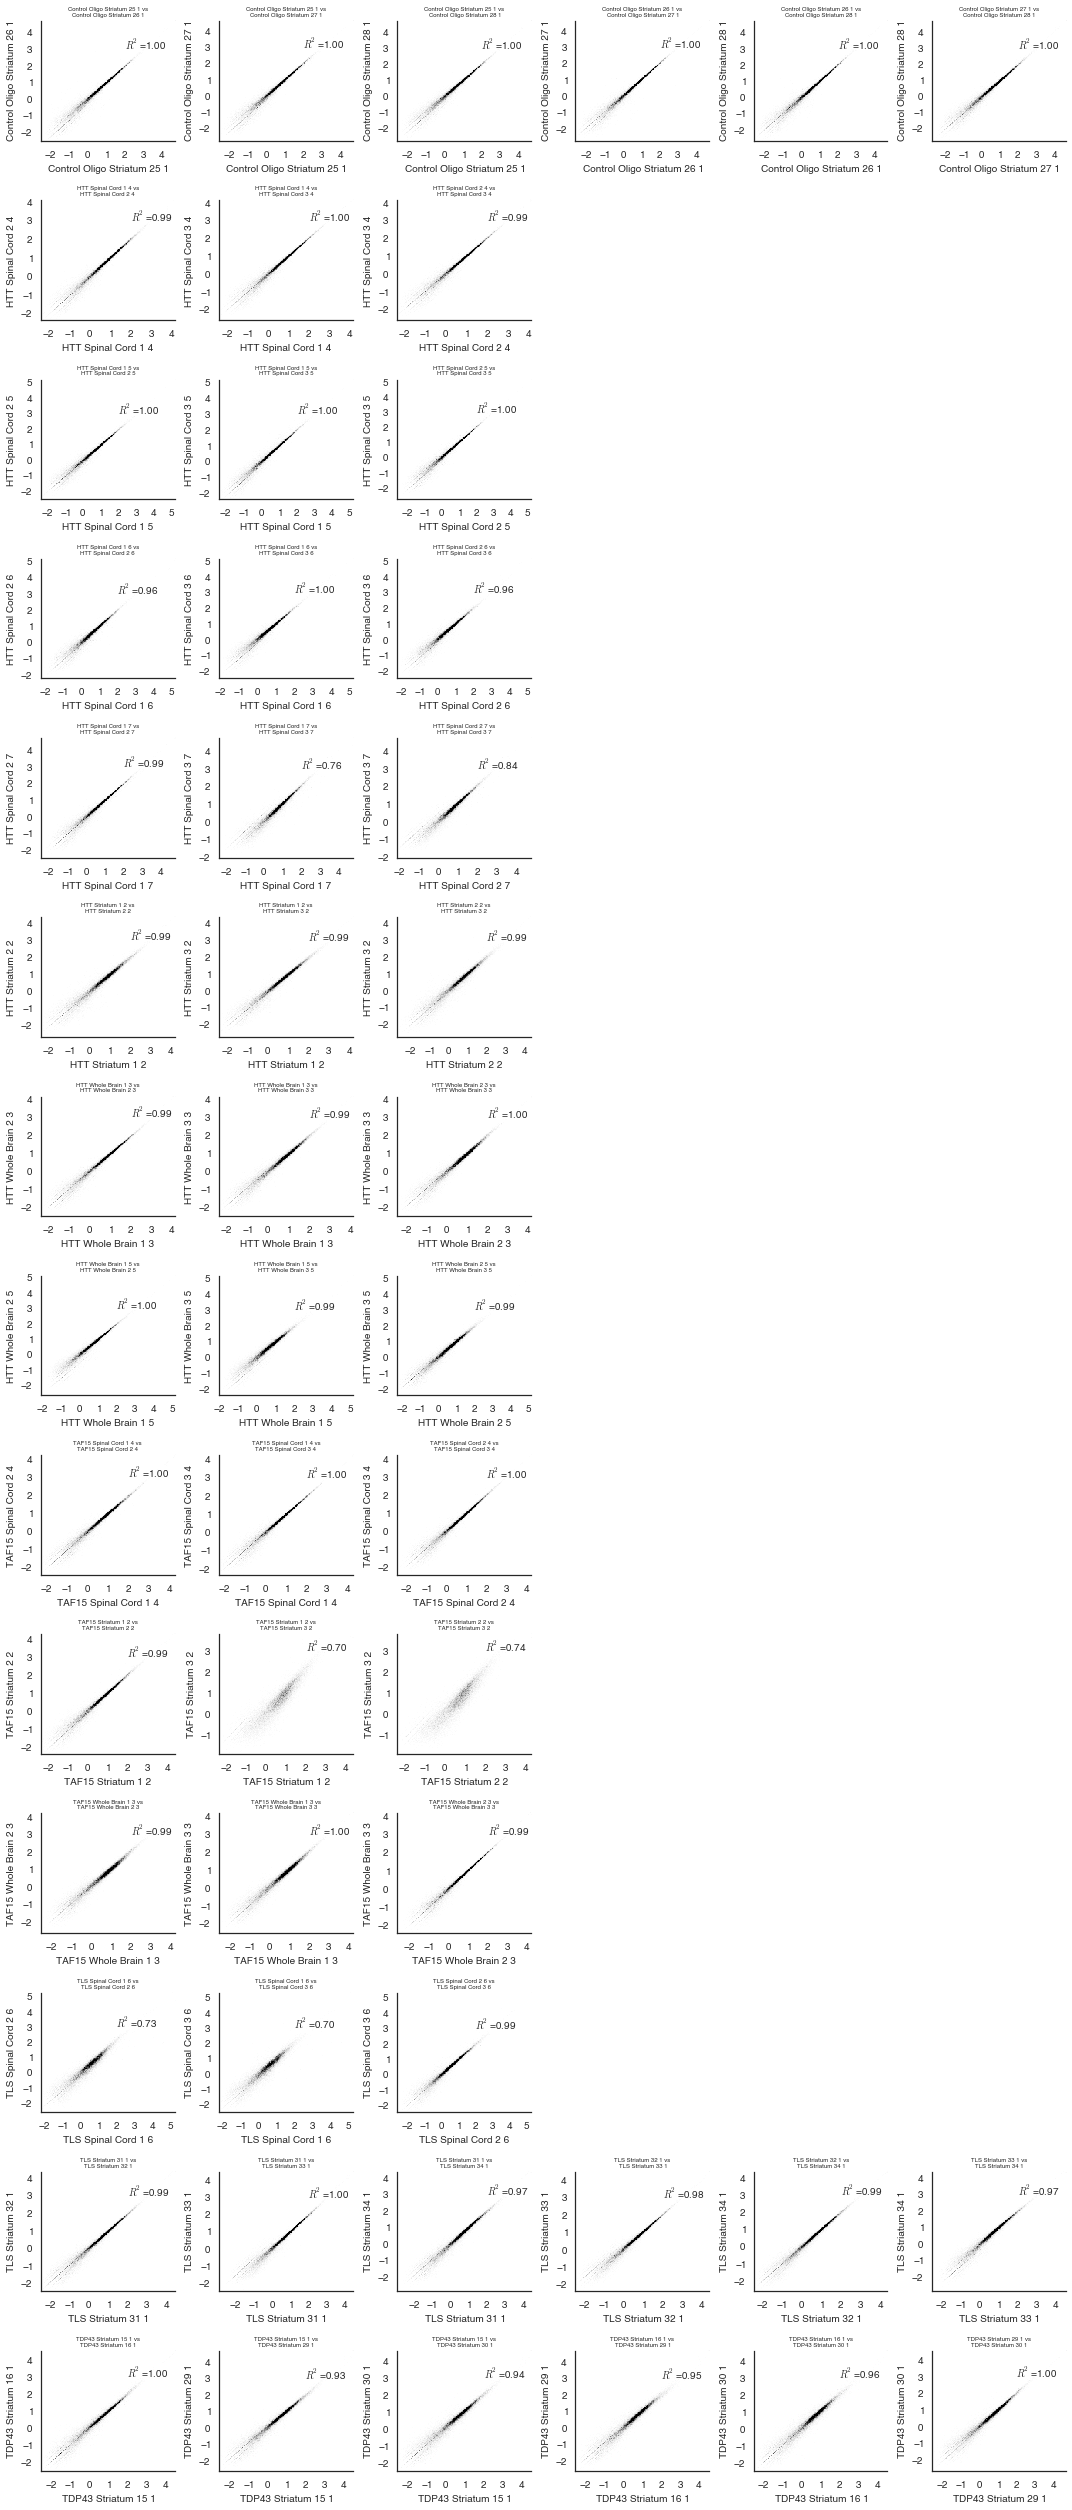

In [15]:
filtered_rpkm = rpkm.ix[['Control Oligo', 'HTT', 'TAF15', 'TLS', 'TDP43']]

max_combinations = np.max(filtered_rpkm.groupby(level=("knockdown", "cell_type", "analysis_group")).count().values)
num_rows = len(list(filtered_rpkm.groupby(level=("knockdown", "cell_type", "analysis_group"))))
num_cols = len(list(itertools.combinations(range(max_combinations), 2)))
print num_rows, num_cols 
with dataviz.Figure(os.path.join(img_dir, "replicate_plotting_filtered.svg"), figsize=(2.5 * num_cols,2.5*num_rows)) as fig:
    gs = gridspec.GridSpec(num_rows, num_cols)
    for x, (name, group) in enumerate(filtered_rpkm.groupby(level=("knockdown", "cell_type", "analysis_group"))):
        for y, (name1, name2) in enumerate(itertools.combinations(group.index, 2)):
            ax = fig.add_subplot(gs[x,y])
            series1 = filtered_rpkm.ix[name1]
            series2 = filtered_rpkm.ix[name2]

            dataviz.loglog_hist2d(series1, series2, ax=ax)
            sns.despine(ax=ax)
            name1 = " ".join(map(str, name1[:-1]))
            name2 = " ".join(map(str, name2[:-1]))
            
            ax.set_xlabel(name1, fontsize=10)
            ax.set_ylabel(name2, fontsize=10)
            r2 = scipy.stats.linregress(series1, series2)[2]
            ax.text(2, 3, "$R^2$={:.2f}".format(r2))
            ax.set_title("{} vs\n{}".format(name1, name2), fontsize=6)
            [tick.set_fontsize(10) for tick in ax.get_xticklabels()]
            [tick.set_fontsize(10) for tick in ax.get_yticklabels()]

#Results from Replicate Analysis
1. TAF 15 Straitum Rep 3 is no good, need to drop
2. TIA1 Whole Brain Rep 1 is also not great, should drop
4. No need to use PBS controls, drop them when looking at differental expression
3. All other datasets look good

In [16]:
flotilla_rpkm = flotilla_rpkm.drop("TAF15_ASO_3")
flotilla_rpkm = flotilla_rpkm.drop("TIA1_Br_1")

In [17]:
#Executing
rpkm = rpkm.drop("PBS", level=0)
rpkm = rpkm.drop("TAF15_ASO_3", level="exp")
rpkm = rpkm.drop("TIA1_Br_1", level="exp")
rpkm = rpkm.drop("HTT_control_3", level="exp")

all_counts = all_counts.drop("TAF15_ASO_3", axis=1)
all_counts = all_counts.drop("TIA1_Br_1", axis=1)
all_counts = all_counts.drop("HTT_control_3", axis=1)

In [299]:
for col in all_counts[all_counts.columns[5:]]:
    pd.DataFrame(all_counts[col]).to_csv("/nas3/gpratt/Dropbox/TAF15/geo/mouse/rnaseq/{}.csv".format(col))

In [298]:
all_counts

Chr  \
Geneid                                                                     
ENSMUSG00000090025.1                                                chr1   
ENSMUSG00000064842.1                                                chr1   
ENSMUSG00000051951.5                                 chr1;chr1;chr1;chr1   
ENSMUSG00000089699.1                                           chr1;chr1   
ENSMUSG00000088390.1                                                chr1   
ENSMUSG00000089420.1                                                chr1   
ENSMUSG00000025900.4                                 chr1;chr1;chr1;chr1   
ENSMUSG00000025902.7                            chr1;chr1;chr1;chr1;chr1   
ENSMUSG00000064376.1                                                chr1   
ENSMUSG00000088000.1                                                chr1   
ENSMUSG00000033845.7                       chr1;chr1;chr1;chr1;chr1;chr1   
ENSMUSG00000025903.8   chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...   
ENSMUSG00000033813.8   chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...   
ENSMUSG00000062588.3                                                chr1   
ENSMUSG00000002459.10       chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1   
ENSMUSG00000091305.1                                                chr1   
ENSMUSG00000085623.1                                      chr1;chr1;chr1   
ENSMUSG00000091665.1                                                chr1   
ENSMUSG00000033793.7   chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...   
ENSMUSG00000025905.7                                 chr1;chr1;chr1;chr1   
ENSMUSG00000093015.1                                                chr1   
ENSMUSG00000033774.4                                                chr1   
ENSMUSG00000025907.7   chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...   
ENSMUSG00000090031.1                                           chr1;chr1   
ENSMUSG00000073741.1                                                chr1   
ENSMUSG00000087247.1                            chr1;chr1;chr1;chr1;chr1   
ENSMUSG00000033740.10  chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...   
ENSMUSG00000051285.9                  chr1;chr1;chr1;chr1;chr1;chr1;chr1   
ENSMUSG00000048538.7                                                chr1   
ENSMUSG00000077244.1                                                chr1   
...                                                                  ...   
ENSMUSG00000064343.1                                                chrM   
ENSMUSG00000064344.1                                                chrM   
ENSMUSG00000064345.1                                                chrM   
ENSMUSG00000064346.1                                                chrM   
ENSMUSG00000064347.1                                                chrM   
ENSMUSG00000064348.1                                                chrM   
ENSMUSG00000064349.1                                                chrM   
ENSMUSG00000064350.1                                                chrM   
ENSMUSG00000064351.1                                                chrM   
ENSMUSG00000064352.1                                                chrM   
ENSMUSG00000064353.1                                                chrM   
ENSMUSG00000064354.1                                                chrM   
ENSMUSG00000064355.1                                                chrM   
ENSMUSG00000064356.3                                                chrM   
ENSMUSG00000064357.1                                                chrM   
ENSMUSG00000064358.1                                                chrM   
ENSMUSG00000064359.1                                                chrM   
ENSMUSG00000064360.1                                                chrM   
ENSMUSG00000064361.1                                                chrM   
ENSMUSG00000065947.3                                                chrM   
ENSMUSG00000064363.1                     

#Output Data for DeSeq

In [18]:
result = {}
for item in rpkm.index: 
    result[item[-1]] = {key: value for value, key in zip(item, rpkm.index.names)}
sampleInfo = pd.DataFrame(result).T 

#sampleInfo.to_csv("/nas3/gpratt/Dropbox/TAF15/Data/mouse_integration/sampleInfo.csv")
#all_counts.T.ix[sampleInfo.index].T.to_csv("/nas3/gpratt/Dropbox/TAF15/Data/mouse_integration/important_counts.csv")

sampleInfo.to_csv("/nas3/gpratt/Dropbox/TAF15/Data/mouse_integration/sampleInfo_v2.csv")
all_counts.T.ix[sampleInfo.index].T.to_csv("/nas3/gpratt/Dropbox/TAF15/Data/mouse_integration/important_counts_v2.csv")

In [19]:
sorted(all_counts.columns)

['A1-SC_ATTACTCG_L002_R1',
 'A2-SC_TCCGGAGA_L002_R1',
 'A3-SC_CGCTCATT_L002_R1',
 'BrHTT1',
 'BrHTT2',
 'BrHTT3',
 'BrPBS1',
 'BrPBS2',
 'BrPBS3',
 'BrTAF1a',
 'BrTAF2a',
 'BrTAF3a',
 'Chr',
 'Control_Br_1',
 'Control_Br_2',
 'Control_Br_3',
 'Control_Sc_1',
 'Control_Sc_2',
 'Control_Sc_3',
 'D1-SC_GAGATTCC_L002_R1',
 'D2-SC_ATTCAGAA-TATAGCCT_L003_R1',
 'D3-SC_GAATTCGT-TATAGCCT_L003_R1',
 'D4-SC_CTGAAGCT-TATAGCCT_L003_R1',
 'EWSR_Sc_1',
 'EWSR_Sc_2',
 'EWSR_Sc_3',
 'EWSR_Sc_4',
 'End',
 'FUS_ASOsc_1_p7_46',
 'FUS_ASOsc_2_p7_46',
 'FUS_ASOsc_3_p7_46',
 'HTT_control_1',
 'HTT_control_2',
 'HTTsc_1_p7_46',
 'HTTsc_2_p7_46',
 'HTTsc_3_p7_46',
 'HuR_Sc_1',
 'HuR_Sc_2',
 'HuR_Sc_3',
 'HuR_Sc_4',
 'Length',
 'MP12_Striatum_A1_Saline_RNAseq',
 'MP14_Striatum_A5_Saline_RNAseq',
 'MP15_Striatum_C1_TDP43_knockdown_81%_RNAseq',
 'MP16_Striatum_C2_TDP43_knockdown_81%_RNAseq',
 'MP17_Striatum_F4_TDP43_knockdown_64%_RNAseq',
 'MP18_embryonic_brain_TLS_knockout_RNAseq',
 'MP19_embryonic_brain_WT_RNAs

#Knockdown Analysis

In [20]:
gene_id_to_name = region_helpers.gene_id_to_name("/nas3/gpratt/gencode/gencode.vM1.annotation.gtf.db")
gene_id_to_type = region_helpers.gene_id_to_type("/nas3/gpratt/gencode/gencode.vM1.annotation.gtf.db")

name_to_gene_id = {value: key for key, value in gene_id_to_name.items()}

In [21]:
feature_frame = pd.DataFrame({"gene_type": gene_id_to_type, "gene_name": gene_id_to_name})

In [22]:
knockdowns = pd.concat({os.path.basename(rbp).split(".")[0]: pd.read_csv(rbp, index_col=0) for rbp in glob.glob("/nas3/gpratt/Dropbox/TAF15/Data/mouse_integration/deseq/*v2.csv")})
knockdowns['gene_names'] = [gene_id_to_name[gene_id] for gene_id in knockdowns.index.get_level_values(level=1)]

results = []
for item in knockdowns.index:
    results.append(item[0].split("_")[:2] + [item[1]])
knockdowns.index = pd.MultiIndex.from_tuples(results, names=["rbp", 'cell_type', "geneid"])
knockdowns = knockdowns.sortlevel()

#Knockdown QC

#MA Plots

In [23]:
def ma_plot(df, ax, sig=.05):
    not_sig = df[df.padj > sig]
    sig = df[df.padj <= sig]
    
    ax.scatter(not_sig.baseMean, not_sig.log2FoldChange, c='g', alpha=.5)
    ax.scatter(sig.baseMean, sig.log2FoldChange, c='b', alpha=.5)
 
    ax.set_xlabel("Base Mean")
    ax.set_ylabel("Log 2 Fold Change")
    ax.set_xscale("log")
    return ax

/nas3/gpratt/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


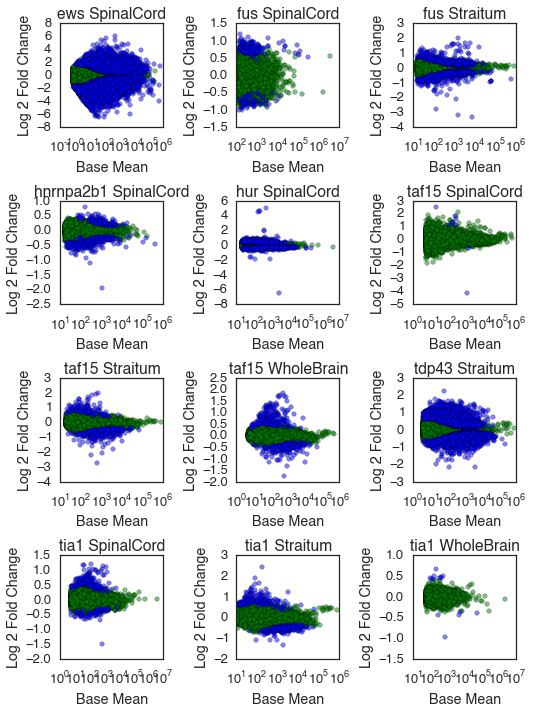

In [24]:
num_rows = 4
num_cols = 3
with dataviz.Figure(os.path.join(img_dir, "ma_plots.svg"), figsize=(2.5 * num_cols,2.5*num_rows)) as fig:
    for x, (group, df) in enumerate(knockdowns.groupby(level=['rbp', 'cell_type'])):
        ax = fig.add_subplot(num_rows, num_cols, x + 1)
        ax = ma_plot(df, ax)
        ax.set_title(" ".join(group))

#Validation Knockdown was Correct for each Gene

Looks like its all good, moving on to analysis

In [25]:
knockdown_genes = knockdowns.ix[['fus', 'taf15', 'tdp43']][knockdowns.gene_names.isin(["Taf15", "Tardbp", "Fus"])]
knockdown_genes = knockdown_genes.xs("Straitum", level=1)

/nas3/gpratt/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1942: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


In [26]:
foo = all_counts.ix['ENSMUSG00000020680.8']

In [27]:
for x in foo.iteritems():
    print x

('Chr', 'chr11;chr11;chr11;chr11;chr11;chr11;chr11;chr11;chr11;chr11;chr11;chr11;chr11;chr11;chr11;chr11;chr11;chr11')
('Start', '83286588;83287110;83294612;83295436;83298153;83298312;83298479;83300725;83302427;83310764;83311396;83312575;83314617;83316262;83317748;83317930;83318144;83319920')
('End', '83286708;83287201;83294683;83295988;83298204;83298396;83298581;83300915;83302715;83310798;83311428;83312684;83314746;83316354;83317829;83318018;83318606;83320245')
('Strand', '+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+')
('Length', 2919)
('HuR_Sc_2', 209)
('MP27_Striatum_D2_control_oligo_RNAseq', 2939)
('MP1_Liver_A1_Saline_RNAseq', 735)
('TIA1_ASO_1', 890)
('MP2_Liver_A2_Saline_RNAseq', 1071)
('MP31_TLS_knockdown_90%_mouse_brain_RNAseq', 4710)
('MP28_Striatum_D3_control_oligo_RNAseq', 2922)
('HTTsc_2_p7_46', 500)
('MP32_TLS_knockdown_90%_mouse_brain_RNAseq', 3673)
('Control_Br_2', 169)
('FUS_ASOsc_2_p7_46', 288)
('MP33_TLS_knockdown_90%_mouse_brain_RNAseq', 1779)
('MP29_Striatum_H2_TDP43_knockd

In [28]:
foo.sort()

/nas/nas0/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  if __name__ == '__main__':
/nas3/gpratt/anaconda/lib/python2.7/site-packages/pandas/core/series.py:1656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)


In [29]:
knockdown_genes

baseMean  log2FoldChange     lfcSE       stat  \
rbp   geneid                                                                    
fus   ENSMUSG00000020680.8   2794.041140        0.614600  0.125162   4.910445   
      ENSMUSG00000030795.12  7291.420911       -3.331586  0.147436 -22.596812   
      ENSMUSG00000041459.8   4339.049603       -0.197706  0.122711  -1.611149   
taf15 ENSMUSG00000020680.8    651.314231       -2.730656  0.170397 -16.025293   
      ENSMUSG00000030795.12  5285.242865       -0.031816  0.117921  -0.269807   
      ENSMUSG00000041459.8   4200.708270        0.137180  0.131901   1.040023   
tdp43 ENSMUSG00000020680.8   2794.041140       -0.121984  0.125340  -0.973221   
      ENSMUSG00000030795.12  7291.420911       -0.514818  0.146271  -3.519617   
      ENSMUSG00000041459.8   4339.049603       -2.166241  0.123525 -17.536913   

                                    pvalue           padj gene_names  
rbp   geneid                                                          
fus   ENSMUSG00000020680.8    9.086974e-07   1.159668e-04      Taf15  
      ENSMUSG00000030795.12  4.658144e-113  8.263081e-109        Fus  
      ENSMUSG00000041459.8    1.071472e-01   4.198552e-01     Tardbp  
taf15 ENSMUSG00000020680.8    8.508823e-58   1.414762e-53      Taf15  
      ENSMUSG00000030795.12   7.873087e-01   9.898589e-01        Fus  
      ENSMUSG00000041459.8    2.983292e-01   9.061598e-01     Tardbp  
tdp43 ENSMUSG00000020680.8    3.304433e-01   5.162544e-01      Taf15  
      ENSMUSG00000030795.12   4.321705e-04   3.378950e-03        Fus  
      ENSMUSG00000041459.8    7.488595e-69   1.565041e-64     Tardbp

In [366]:
width

0.5

In [367]:
ind

array([0, 1, 2])

In [368]:
knockdown_genes[knockdown_genes['gene_names'] == "Taf15"].log2FoldChange.values

array([ 0.61460023, -2.73065607, -0.12198356])

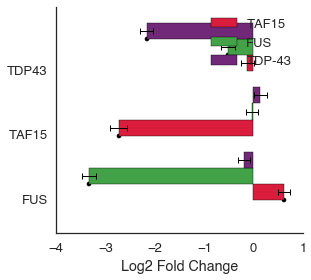

In [365]:
num_rows = 1
num_cols = 2
width=.50
ind = np.arange(len(knockdown_genes[knockdown_genes['gene_names'] == "Taf15"].log2FoldChange.values))

with dataviz.Figure(os.path.join(img_dir, "differental_expression_plot.svg"), figsize=(4 * num_cols,4*num_rows)) as fig:
    gs = gridspec.GridSpec(num_rows, num_cols)

    ax = fig.add_subplot(gs[0,0])

    ax.barh(ind, 
            knockdown_genes[knockdown_genes['gene_names'] == "Taf15"].log2FoldChange.values, 
            width / 2, 
            color=rbp_colors['taf15'], 
            label="TAF15",
            xerr = knockdown_genes[knockdown_genes['gene_names'] == "Taf15"].lfcSE.values,
           error_kw=dict(ecolor='black', lw=1, capsize=3, capthick=1))
    ax.barh(ind + (width / 2) , 
            knockdown_genes[knockdown_genes['gene_names'] == "Fus"].log2FoldChange.values,
            width / 2, 
            color=rbp_colors['fus'], 
            label="FUS",
           xerr = knockdown_genes[knockdown_genes['gene_names'] == "Fus"].lfcSE.values,
           error_kw=dict(ecolor='black', lw=1, capsize=3, capthick=1))
    ax.barh(ind + (width),
            knockdown_genes[knockdown_genes['gene_names'] == "Tardbp"].log2FoldChange.values, width / 2,
            color=rbp_colors['tdp43'], 
            label="TDP-43",
           xerr = knockdown_genes[knockdown_genes['gene_names'] == "Tardbp"].lfcSE.values,
           error_kw=dict(ecolor='black', lw=1, capsize=3, capthick=1))
    
    ax.legend(loc=1)
    sns.despine()
    ax.set_xlabel("Log2 Fold Change")
    yticks = ax.get_yticks()
    
    locations = list(itertools.chain(*zip(ind, ind + (width / 2), ind + (width))))
    scatter_locs = []
    for (name, row), loc in zip(knockdown_genes.iterrows(), locations):
        if row.padj < .05:
            scatter_locs.append((row.log2FoldChange, loc))
                    
    scatter_x = [x for x,y in scatter_locs]
    scatter_y = [y for x,y in scatter_locs]
    ax.scatter(scatter_x, scatter_y, marker=(15, 2, 30), color='k')
    
    ax.set_yticks(ind)
    ax.set_yticklabels([rbp_names["_".join(item[:1])] for item in knockdown_genes[knockdown_genes.gene_names == "Taf15"].index])



#PCA

In [31]:
flotilla_metadata['phenotype'] = [cell_type + " " + rbp for cell_type, rbp in zip(flotilla_metadata['Cell Type'], flotilla_metadata['rbp'])]

In [32]:
flotilla_metadata

Location  \
Biological Replicate                                                                             
A1-SC_ATTACTCG_L002_R1                       /home/gpratt/projects/fet_family/data/mouse_rn...   
A2-SC_TCCGGAGA_L002_R1                       /home/gpratt/projects/fet_family/data/mouse_rn...   
A3-SC_CGCTCATT_L002_R1                       /home/gpratt/projects/fet_family/data/mouse_rn...   
BrHTT1                                       /home/gpratt/projects/fet_family/data/mouse_rn...   
BrHTT2                                       /home/gpratt/projects/fet_family/data/mouse_rn...   
BrHTT3                                       /home/gpratt/projects/fet_family/data/mouse_rn...   
BrPBS1                                       /home/gpratt/projects/fet_family/data/mouse_rn...   
BrPBS2                                       /home/gpratt/projects/fet_family/data/mouse_rn...   
BrPBS3                                       /home/gpratt/projects/fet_family/data/mouse_rn...   
BrTAF1a                                      /home/gpratt/projects/fet_family/data/mouse_rn...   
BrTAF2a                                      /home/gpratt/projects/fet_family/data/mouse_rn...   
BrTAF3a                                      /home/gpratt/projects/fet_family/data/mouse_rn...   
Control_Br_1                                 /home/gpratt/projects/fet_family/data/tia1/KB0...   
Control_Br_2                                 /home/gpratt/projects/fet_family/data/tia1/KB0...   
Control_Br_3                                 /home/gpratt/projects/fet_family/data/tia1/KB0...   
Control_Sc_1                                 /home/gpratt/projects/fet_family/data/tia1/KB1...   
Control_Sc_2                                 /home/gpratt/projects/fet_family/data/tia1/KB1...   
Control_Sc_3                                 /home/gpratt/projects/fet_family/data/tia1/KB1...   
D1-SC_GAGATTCC_L002_R1                       /home/gpratt/projects/fet_family/data/mouse_rn...   
D2-SC_ATTCAGAA-TATAGCCT_L003_R1              /home/gpratt/projects/fet_family/data/mouse_rn...   
D3-SC_GAATTCGT-TATAGCCT_L003_R1              /home/gpratt/projects/fet_family/data/mouse_rn...   
D4-SC_CTGAAGCT-TATAGCCT_L003_R1              /home/gpratt/projects/fet_family/data/mouse_rn...   
EWSR_Sc_1                                    /home/gpratt/projects/fet_family/data/mouse_rn...   
EWSR_Sc_2                                    /home/gpratt/projects/fet_family/data/mouse_rn...   
EWSR_Sc_3                                    /home/gpratt/projects/fet_family/data/mouse_rn...   
EWSR_Sc_4                                    /home/gpratt/projects/fet_family/data/mouse_rn...   
FUS_ASOsc_1_p7_46                            /home/gpratt/projects/fet_family/data/mouse_rn...   
FUS_ASOsc_2_p7_46                            /home/gpratt/projects/fet_family/data/mouse_rn...   
FUS_ASOsc_3_p7_46                            /home/gpratt/projects/fet_family/data/mouse_rn...   
HTT_control_1                                /home/gpratt/projects/fet_family/data/mouse_rn...   
...                                                                                        ...   
MP25_Striatum_C2_control_oligo_RNAseq        /home/gpratt/projects/fet_family/data/mouse_rn...   
MP26_Striatum_C4_control_oligo_RNAseq        /home/gpratt/projects/fet_family/data/mouse_rn...   
MP27_Striatum_D2_control_oligo_RNAseq        /home/gpratt/projects/fet_family/data/mouse_rn...   
MP28_Striatum_D3_control_oligo_RNAseq        /home/gpratt/projects/fet_family/data/mouse_rn...   
MP29_Striatum_H2_TDP43_knockdown_78%_RNAseq  /home/gpratt/projects/fet_family/data/mouse_rn...   
MP30_Striatum_K2_TDP43_knockdown_80%_RNAseq  /home/gpratt/projects/fet_family/data/mouse_rn...   
MP31_TLS_knockdown_90%_mouse_brain_RNAseq    /home/gpratt/projects/fet_family/data/mouse_rn...   
MP32_TLS_knockdown_90%_mouse_brain_RNAseq    /home/gpratt/projects/fet_family/data/mouse_rn...   
MP33_TLS_knockdown_90%_mouse_brain_RNAseq    /home/gpratt/projects/f

In [33]:
flotilla_rpkm

Geneid                                       ENSMUSG00000090025.1  \
Biological Replicate                                                
A1-SC_ATTACTCG_L002_R1                                   0.000000   
A2-SC_TCCGGAGA_L002_R1                                   0.000000   
A3-SC_CGCTCATT_L002_R1                                   0.000000   
BrHTT1                                                   0.000000   
BrHTT2                                                   0.000000   
BrHTT3                                                   0.000000   
BrPBS1                                                   0.000000   
BrPBS2                                                   0.000000   
BrPBS3                                                   0.000000   
BrTAF1a                                                  0.000000   
BrTAF2a                                                  0.000000   
BrTAF3a                                                  0.000000   
Control_Br_1                                             0.000000   
Control_Br_2                                             0.000000   
Control_Br_3                                             0.000000   
Control_Sc_1                                             0.000000   
Control_Sc_2                                             0.000000   
Control_Sc_3                                             0.000000   
D1-SC_GAGATTCC_L002_R1                                   0.000000   
D2-SC_ATTCAGAA-TATAGCCT_L003_R1                          0.000000   
D3-SC_GAATTCGT-TATAGCCT_L003_R1                          0.000000   
D4-SC_CTGAAGCT-TATAGCCT_L003_R1                          0.000000   
EWSR_Sc_1                                                0.000000   
EWSR_Sc_2                                                0.000000   
EWSR_Sc_3                                                0.000000   
EWSR_Sc_4                                                0.000000   
FUS_ASOsc_1_p7_46                                        0.000000   
FUS_ASOsc_2_p7_46                                        0.000000   
FUS_ASOsc_3_p7_46                                        0.000000   
HTT_control_1                                            0.000000   
...                                                           ...   
MP15_Striatum_C1_TDP43_knockdown_81%_RNAseq              0.057421   
MP16_Striatum_C2_TDP43_knockdown_81%_RNAseq              0.000000   
MP25_Striatum_C2_control_oligo_RNAseq                    0.000000   
MP26_Striatum_C4_control_oligo_RNAseq                    0.000000   
MP27_Striatum_D2_control_oligo_RNAseq                    0.000000   
MP28_Striatum_D3_control_oligo_RNAseq                    0.000000   
MP29_Striatum_H2_TDP43_knockdown_78%_RNAseq              0.000000   
MP30_Striatum_K2_TDP43_knockdown_80%_RNAseq              0.071035   
MP31_TLS_knockdown_90%_mouse_brain_RNAseq                0.000000   
MP32_TLS_knockdown_90%_mouse_brain_RNAseq                0.000000   
MP33_TLS_knockdown_90%_mouse_brain_RNAseq                0.000000   
MP34_TLS_knockdown_90%_mouse_brain_RNAseq                0.000000   
ScHTT1                                                   0.000000   
ScHTT2                                                   0.000000   
ScHTT3                                                   0.000000   
ScPBS1                                                   0.000000   
ScPBS2                                                   0.000000   
ScPBS3                                                   0.000000   
ScTAF1a                                                  0.000000   
ScTAF2a                                                  0.000000   
ScTAF3a                                                  0.000000   
TAF15_ASO_1                                              0.000000   
TAF15_ASO_2                                              0.000000   
TIA1_ASO_1                                               0.000000   
TIA1_ASO_2                                               0.000000  

In [34]:
study = flotilla.Study(# The metadata describing phenotype and pooled samples
                       flotilla_metadata,
                       version='0.1.0',
                       expression_data = flotilla_rpkm,
                       expression_thresh = 1,
                       species="mm9",
#                        expression_feature_rename_col = "gene_name",
#                        expression_feature_data = feature_frame 
)
study.expression.feature_data = feature_frame
study.expression.feature_rename_col = "gene_name"

2015-11-25 09:44:06	Initializing Study
2015-11-25 09:44:06	Initializing Predictor configuration manager for Study
2015-11-25 09:44:06	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2015-11-25 09:44:06	Added ExtraTreesClassifier to default predictors
2015-11-25 09:44:06	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2015-11-25 09:44:06	Added ExtraTreesRegressor to default predictors
2015-11-25 09:44:06	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2015-11-25 09:44:06	Added GradientBoostingClassifier to default predictors
2015-11-25 09:44:06	Predictor GradientBoostingRegressor is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
2015-11-25 09:44:06	Added GradientBoostingRegressor to default predictors
2015-11-25 09:44:06	Loading metadata
2015-11-25 09:44:06	Loading species metadata from ~/f

No phenotype to color mapping was provided, falling back on reasonable defaults.
No phenotype to marker (matplotlib plotting symbol) was provided, so each phenotype will be plotted as a circle in visualizations.
Error loading species mm9 data 

2015-11-25 09:44:07	Loading expression data
2015-11-25 09:44:07	Initializing expression
2015-11-25 09:44:07	Done initializing expression
2015-11-25 09:44:07	Successfully initialized a Study object!


In [35]:
#study.plot_pca(feature_subset="gene_type: protein_coding")

Figure Legend: PCA Plot of only all Knockdown and control conditions for only protein coding genes

In [36]:
#study.metadata.phenotype_to_color = {key: value for key, value in zip(study.metadata.phenotype_to_color, result)}
#dv = study.plot_pca(feature_subset="gene_type: protein_coding",
#                    sample_subset="Cell Type: Striatum")

Figure Legend: PCA Plot of only all Knockdown and control conditions for only protein coding genes in striatum

In [37]:
#study.metadata.phenotype_to_color = {key: value for key, value in zip(study.metadata.phenotype_to_color, result)}
#dv = study.plot_pca(feature_subset="gene_type: protein_coding",
#                    sample_subset="analysis_group: 1")

Figure Legend: PCA Plot of only all Knockdown and control conditions for only protein coding genes in analysis group 1 (subset of experiments done at the same time with same control)

In [38]:
#dv = study.plot_pca(feature_subset="gene_type: protein_coding",
#                    sample_subset="analysis_group: 2")

In [39]:
#dv = study.plot_pca(feature_subset="gene_type: protein_coding",
#                    sample_subset="analysis_group: 3")

In [40]:
#dv = study.plot_pca(feature_subset="gene_type: protein_coding",
#                    sample_subset="analysis_group: 4")

Figure Legend: PCA Plot of only all Knockdown and control conditions for only protein coding genes in analysis group 4 (subset of experiments done at the same time with same control)

In [41]:
#dv = study.plot_pca(feature_subset="gene_type: protein_coding",
#                    sample_subset="analysis_group: 5")

Figure Legend: PCA Plot of only all Knockdown and control conditions for only protein coding genes in analysis group 5 (subset of experiments done at the same time with same control)

In [42]:
#dv = study.plot_pca(feature_subset="gene_type: protein_coding",
#                    sample_subset="analysis_group: 6")

In [43]:
#dv = study.plot_pca(feature_subset="gene_type: protein_coding",
#                    sample_subset="analysis_group: 7")

In [44]:
#study.interactive_pca()

#Knockdown Analysis

In [45]:
significant_knockdowns = knockdowns[(knockdowns.padj <= .05)  & (abs(knockdowns.log2FoldChange) > np.log2(1.5))]
unchanging_knockdowns = knockdowns[~((knockdowns.padj <= .05) & (abs(knockdowns.log2FoldChange) > np.log2(1.5)))]

signifcant_upregulated = significant_knockdowns[significant_knockdowns.log2FoldChange > 0]
signifcant_downregulated = significant_knockdowns[significant_knockdowns.log2FoldChange < 0]

In [46]:
for name, df in significant_knockdowns.groupby(level=["rbp", "cell_type"]):
    df.to_csv("/nas3/gpratt/Dropbox/TAF15_Manuscript/Tables/{}.csv".format("_".join(name)))

In [47]:
significant_knockdowns.groupby(level=["rbp", 'cell_type']).count().padj 

rbp        cell_type 
ews        SpinalCord    13002
fus        SpinalCord      171
           Straitum        284
hnrnpa2b1  SpinalCord       29
hur        SpinalCord      148
taf15      SpinalCord        9
           Straitum        285
           WholeBrain      191
tdp43      Straitum       2034
tia1       SpinalCord       80
           Straitum        236
           WholeBrain        2
Name: padj, dtype: int64

In [48]:
signifcant_downregulated.groupby(level=["rbp", 'cell_type']).count().padj 

rbp        cell_type 
ews        SpinalCord    6766
fus        SpinalCord      47
           Straitum       170
hnrnpa2b1  SpinalCord      28
hur        SpinalCord      29
taf15      SpinalCord       2
           Straitum       194
           WholeBrain      50
tdp43      Straitum       646
tia1       SpinalCord       6
           Straitum        73
           WholeBrain       1
Name: padj, dtype: int64

In [49]:
signifcant_upregulated.groupby(level=["rbp", 'cell_type']).count().padj 

rbp        cell_type 
ews        SpinalCord    6236
fus        SpinalCord     124
           Straitum       114
hnrnpa2b1  SpinalCord       1
hur        SpinalCord     119
taf15      SpinalCord       7
           Straitum        91
           WholeBrain     141
tdp43      Straitum      1388
tia1       SpinalCord      74
           Straitum       163
           WholeBrain       1
Name: padj, dtype: int64

In [50]:
expressed_only_in_spial_cord = set(significant_knockdowns.ix['taf15', 'SpinalCord'].index) - set(significant_knockdowns.ix['taf15', 'WholeBrain'].index)

In [51]:
significant_knockdowns.ix['taf15', 'SpinalCord'].ix[expressed_only_in_spial_cord]

baseMean  log2FoldChange     lfcSE      stat  \
geneid                                                                  
ENSMUSG00000068129.4    22.516677        2.528233  0.544737  4.641196   
ENSMUSG00000090698.1   184.661821        1.382627  0.304702  4.537643   
ENSMUSG00000028195.3   273.278128        1.791924  0.277901  6.448059   
ENSMUSG00000041078.6  1836.577686       -0.641689  0.117640 -5.454689   
ENSMUSG00000061132.7   125.087424        1.121641  0.236669  4.739279   
ENSMUSG00000020423.6   332.514075        1.119787  0.251356  4.454990   

                            pvalue      padj gene_names  
geneid                                                   
ENSMUSG00000068129.4  3.463979e-06  0.009852       Cst7  
ENSMUSG00000090698.1  5.688638e-06  0.014157     Apold1  
ENSMUSG00000028195.3  1.132916e-10  0.000001      Cyr61  
ENSMUSG00000041078.6  4.905873e-08  0.000326      Grid1  
ENSMUSG00000061132.7  2.144801e-06  0.007117       Blnk  
ENSMUSG00000020423.6  8.389729e-06  0.018559       Btg2

In [52]:
#HTML(signifcant_downregulated.ix['taf15'].to_html())

In [53]:
HTML(signifcant_upregulated.ix['taf15'].to_html())

/nas3/gpratt/anaconda/lib/python2.7/site-packages/pandas/core/index.py:4281: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return np.sum(name == np.asarray(self.names)) > 1


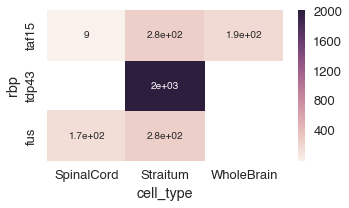

In [54]:
with dataviz.Figure(os.path.join(img_dir, "number_of_changing_genes.svg"), figsize=(5, 3)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.heatmap(significant_knockdowns.ix[['taf15', 'tdp43', 'fus']].groupby(level=['rbp', 'cell_type']).count().padj.unstack(), 
                ax=ax, annot=True)

Figure Legend: Total Number of Significantly Changing Genes in FUS, TDP43 and TAF15 in Spinal Cord Straitum and Whole Brain

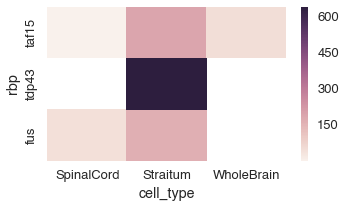

In [55]:
with dataviz.Figure(os.path.join(img_dir, "number_of_changing_genes.svg"), figsize=(5, 3)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.heatmap(signifcant_downregulated.ix[['taf15', 'tdp43', 'fus']].groupby(level=['rbp', 'cell_type']).count().padj.unstack(), ax=ax)

Figure Legend: Total Number of Significantly downregulated Genes in FUS, TDP43 and TAF15 in Spinal Cord Straitum and Whole Brain

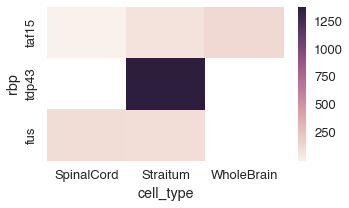

In [56]:
with dataviz.Figure(os.path.join(img_dir, "number_of_changing_genes.svg"), figsize=(5, 3)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.heatmap(signifcant_upregulated.ix[['taf15', 'tdp43', 'fus']].groupby(level=['rbp', 'cell_type']).count().padj.unstack(), ax=ax)

Figure Legend: Total Number of Significantly upregulated Genes in FUS, TDP43 and TAF15 in Spinal Cord Straitum and Whole Brain

#TAF15 Tissue Specific analysis

Count Number of overlapping Changes for text
----

In [57]:
print "overlap down", len(signifcant_downregulated.ix['taf15', 'SpinalCord'].index & signifcant_downregulated.ix['taf15', 'Straitum'].index & signifcant_downregulated.ix['taf15', 'WholeBrain'].index)
print "all down", len(signifcant_downregulated.ix['taf15', 'SpinalCord'].index | signifcant_downregulated.ix['taf15', 'Straitum'].index | signifcant_downregulated.ix['taf15', 'WholeBrain'].index)

print "overlap up", len(signifcant_upregulated.ix['taf15', 'SpinalCord'].index & signifcant_upregulated.ix['taf15', 'Straitum'].index & signifcant_upregulated.ix['taf15', 'WholeBrain'].index)
print "all up", len(signifcant_upregulated.ix['taf15', 'SpinalCord'].index | signifcant_upregulated.ix['taf15', 'Straitum'].index | signifcant_upregulated.ix['taf15', 'WholeBrain'].index)

print "total differentaly expressed genes", 206 + 182

overlap down 1
all down 226
overlap up 0
all up 178
total differentaly expressed genes 388


In [58]:
signifcant_downregulated

baseMean  log2FoldChange     lfcSE  \
rbp  cell_type  geneid                                                          
ews  SpinalCord ENSMUSG00000000001.4     868.849599       -1.311316  0.271571   
                ENSMUSG00000000037.9      54.382687       -1.471627  0.512326   
                ENSMUSG00000000056.7    1134.008478       -0.645249  0.117942   
                ENSMUSG00000000078.6     952.758033       -0.919000  0.099193   
                ENSMUSG00000000127.7     434.858838       -1.795564  0.245386   
                ENSMUSG00000000167.8      29.667514       -1.296903  0.491650   
                ENSMUSG00000000168.3    2287.072128       -0.701361  0.201809   
                ENSMUSG00000000197.6    2167.987749       -1.663975  0.224858   
                ENSMUSG00000000223.6    1635.865122       -0.605613  0.123602   
                ENSMUSG00000000263.9    9230.975795       -0.920130  0.108314   
                ENSMUSG00000000266.5     779.822043       -2.094516  0.276355   
                ENSMUSG00000000276.5    1849.985370       -1.046579  0.235734   
                ENSMUSG00000000317.5      45.800760       -0.861684  0.293888   
                ENSMUSG00000000340.6     474.534932       -1.600568  0.272158   
                ENSMUSG00000000355.6     647.010148       -1.594736  0.382238   
                ENSMUSG00000000402.2     279.204651       -0.602832  0.274583   
                ENSMUSG00000000416.9    2224.596856       -0.953210  0.204942   
                ENSMUSG00000000420.8    1876.164202       -1.107275  0.198205   
                ENSMUSG00000000560.5    1079.217649       -2.122186  0.277974   
                ENSMUSG00000000581.2     695.108708       -1.483517  0.357024   
                ENSMUSG00000000600.8     989.327081       -1.699817  0.284598   
                ENSMUSG00000000606.8       8.785272       -2.484002  0.724017   
                ENSMUSG00000000708.8    1442.773841       -1.285691  0.212262   
                ENSMUSG00000000766.11    258.741700       -2.475924  0.217376   
                ENSMUSG00000000787.6    7350.400597       -2.029233  0.248712   
                ENSMUSG00000000804.8    3304.466007       -2.150856  0.194259   
                ENSMUSG00000000826.10   9588.553897       -0.884577  0.131261   
                ENSMUSG00000000838.10   1536.454933       -1.475565  0.187164   
                ENSMUSG00000000869.6       2.540915       -1.809655  0.752969   
                ENSMUSG00000001016.8    1500.400924       -0.599034  0.128222   
...                                             ...             ...       ...   
tia1 Straitum   ENSMUSG00000040390.7    3076.715199       -0.606284  0.142374   
                ENSMUSG00000040794.4    1545.705720       -0.650835  0.169754   
                ENSMUSG00000041889.7    1456.476642       -0.713085  0.173812   
                ENSMUSG00000044024.8    1432.014075       -0.621827  0.123197   
                ENSMUSG00000046546.3     165.302557       -0.668721  0.204598   
                ENSMUSG00000046613.11    493.048609       -0.701462  0.195342   
                ENSMUSG00000048142.8    5529.496441       -0.601397  0.124410   
                ENSMUSG00000048385.8    2160.669666       -0.690083  0.142202   
                ENSMUSG00000048826.6    1315.095795       -0.607502  0.148596   
                ENSMUSG00000049649.8     134.966295       -0.724338  0.215302   
                ENSMUSG00000050405.8     300.028806       -0.736951  0.197078   
                ENSMUSG00000050761.3     287.510253       -0.612326  0.181485   
                ENSMUSG00000050854.3     328.747685       -0.631310  0.186546   
                ENSMUSG00000051703.8     743.827544       -0.588667  0.141883   
                ENSMUSG00000051726.4    1611.815263       -0.684161  0.139298   
                ENSMUSG00000051985.5      93.681502       -1.096062  0.225628   
                ENSMUSG00000053166.7     643.700563       -0.616271  0.174

/nas3/gpratt/anaconda/lib/python2.7/site-packages/matplotlib_venn/_venn3.py:239: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  return (len(a - (b.union(c))),  # TODO: This is certainly not the most efficient way to compute.
/nas3/gpratt/anaconda/lib/python2.7/site-packages/matplotlib_venn/_venn3.py:240: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  len(b - (a.union(c))),
/nas3/gpratt/anaconda/lib/python2.7/site-packages/matplotlib_venn/_venn3.py:241: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  len(a.intersection(b) - c),
/nas3/gpratt/anaconda/lib/python2.7/site-packages/matplotlib_venn/_venn3.py:242: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  len(c - (a.union(b))),
/nas3/gpratt/anaconda/lib/python2.7/site-packages/matplotlib_venn/_venn3.py:243: FutureWarning: using '-'

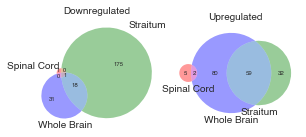

In [59]:
with dataviz.Figure(os.path.join(img_dir, "taf15_tissue_specific_changes.svg"), figsize=(4, 2)) as fig:
    ax = fig.add_subplot(1,2,1)
    venn = venn3([signifcant_downregulated.ix['taf15', 'SpinalCord'].index,
                  signifcant_downregulated.ix['taf15', 'Straitum'].index,
                  signifcant_downregulated.ix['taf15', 'WholeBrain'].index,],
            set_labels=("Spinal Cord", "Straitum", "Whole Brain"), 
            set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), ax=ax)
    ax.set_title("Downregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels  if label is not None]
    
    ax = fig.add_subplot(1,2,2)
    venn = venn3([signifcant_upregulated.ix['taf15', 'SpinalCord'].index,
                  signifcant_upregulated.ix['taf15', 'Straitum'].index,
                  signifcant_upregulated.ix['taf15', 'WholeBrain'].index,],
            set_labels=("Spinal Cord", "Straitum", "Whole Brain"),
            set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), ax=ax)
    ax.set_title("Upregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels if label is not None]

Figure Legend: Co-Down and Up Regulated Genes for TAF15 in Spinal Cord, Straitum and Whole Brain

In [60]:
img_dir

'/nas3/gpratt/Dropbox/TAF15/Data/mouse_integration'

In [297]:
1 + 8 + 84 + 101

194

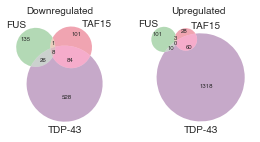

In [61]:
with dataviz.Figure(os.path.join(img_dir, "fet_family_straitum_overlap.svg"), figsize=(4, 2)) as fig:
    ax = fig.add_subplot(1,2,1)
    venn = venn3([signifcant_downregulated.ix['fus', 'Straitum'].index,
    signifcant_downregulated.ix['taf15', 'Straitum'].index,
    signifcant_downregulated.ix['tdp43', 'Straitum'].index,],
            set_labels=("FUS", "TAF15", "TDP-43"), 
            set_colors=(rbp_colors['fus'], rbp_colors['taf15'], rbp_colors['tdp43']), ax=ax)

    ax.set_title("Downregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels if label is not None]
    
    ax = fig.add_subplot(1,2,2)
    venn = venn3([signifcant_upregulated.ix['fus', 'Straitum'].index,
    signifcant_upregulated.ix['taf15', 'Straitum'].index,
    signifcant_upregulated.ix['tdp43', 'Straitum'].index,],
            set_labels=("FUS", "TAF15", "TDP-43"),
            set_colors=(rbp_colors['fus'], rbp_colors['taf15'], rbp_colors['tdp43']), ax=ax)

    ax.set_title("Upregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels if label is not None]

Figure Legend: Co-down and up regulated Genes in Straitum comparing FUS, TAF15 and TDP43

In [62]:
[gene_id_to_name[gene_id] for gene_id in signifcant_downregulated.ix['fus', 'Straitum'].index & signifcant_downregulated.ix['taf15', 'Straitum'].index & signifcant_downregulated.ix['tdp43', 'Straitum'].index]

['Park2', 'Nrxn1', 'Kcnip4', 'Lrp1b', 'St6galnac3', 'Smyd3', 'Alk', 'Csmd1']

In [63]:
[gene_id_to_name[gene_id] for gene_id in signifcant_upregulated.ix['fus', 'Straitum'].index & signifcant_upregulated.ix['taf15', 'Straitum'].index & signifcant_upregulated.ix['tdp43', 'Straitum'].index]

[]

In [64]:
#HTML(signifcant_downregulated.ix['fus'].to_html())

In [65]:
signifcant_downregulated.ix['fus', 'Straitum'].index & signifcant_downregulated.ix['taf15', 'Straitum'].index & signifcant_downregulated.ix['tdp43', 'Straitum'].index

Index([u'ENSMUSG00000023826.7', u'ENSMUSG00000024109.10',
       u'ENSMUSG00000029088.8', u'ENSMUSG00000049252.10',
       u'ENSMUSG00000052544.5', u'ENSMUSG00000055067.8',
       u'ENSMUSG00000055471.6', u'ENSMUSG00000060924.7'],
      dtype='object', name=u'geneid')

In [66]:
signifcant_upregulated.ix['fus', 'Straitum'].index & signifcant_upregulated.ix['taf15', 'Straitum'].index 

Index([u'ENSMUSG00000048721.2', u'ENSMUSG00000064352.1',
       u'ENSMUSG00000091282.1'],
      dtype='object', name=u'geneid')

In [67]:
mm9go = GO.mm9GO()

In [68]:
mapper = {
('ews', 'SpinalCord'): ("HTT", "Spinal Cord", 4),
('fus', 'SpinalCord'): ("HTT", "Spinal Cord", 6),
('fus', 'Straitum'): ("Control Oligo", "Striatum", 1),
('hnrnpa2b1', 'SpinalCord'): ("HTT", "Spinal Cord", 7),
('hur', 'SpinalCord'): ("HTT", "Spinal Cord", 5),
('taf15', 'SpinalCord'): ("HTT", "Spinal Cord", 4),
('taf15', 'Straitum'): ("HTT", "Striatum", 2),
('taf15', 'WholeBrain'): ("HTT", "Whole Brain", 3),
('tdp43', 'Straitum'): ("Control Oligo", "Striatum", 1),
('tia1', 'SpinalCord'): ("HTT", "Spinal Cord", 5),
('tia1', 'Straitum'): ("HTT", "Striatum", 2),
('tia1', 'WholeBrain'): ("HTT", "Whole Brain", 5),
}

In [69]:
downregulated_go = {}
for name, df in signifcant_downregulated.groupby(level=["rbp", "cell_type"]):
    mapping = mapper[name]
    indexer = mapping[:-1]
    analysis_group = mapping[-1]
    
    control_rpkms = rpkm.xs(analysis_group, level="analysis_group").ix[indexer]
    expressed_genes = gencode_to_ensembl(control_rpkms[control_rpkms > 1].dropna(axis=1).columns)
    downregulated_go[name] = mm9go.enrichment(gencode_to_ensembl(df.index.get_level_values("geneid")),
                                              background=expressed_genes)
downregulated_go = pd.concat(downregulated_go, names=["rbp", 'cell_type', "GO Term ID"]).dropna()

upregulated_go = {}
for name, df in signifcant_upregulated.groupby(level=["rbp", "cell_type"]):
    
    mapping = mapper[name]
    indexer = mapping[:-1]
    analysis_group = mapping[-1]
    
    control_rpkms = rpkm.xs(analysis_group, level="analysis_group").ix[indexer]
    expressed_genes = gencode_to_ensembl(control_rpkms[control_rpkms > 1].dropna(axis=1).columns)
    upregulated_go[name] = mm9go.enrichment(gencode_to_ensembl(df.index.get_level_values("geneid")),
                                            background=expressed_genes)
upregulated_go = pd.concat(upregulated_go, names=["rbp", 'cell_type', "GO Term ID"])
all_go = pd.concat({"upregulated": upregulated_go, "downregulated": downregulated_go}).dropna()
all_go = all_go[all_go['Bonferroni-corrected Hypergeometric p-Value'] < .05]

/nas3/gpratt/anaconda/lib/python2.7/site-packages/gscripts-0.1.6-py2.7.egg/gscripts/GO/GO.py:88: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df = df.sort('Bonferroni-corrected Hypergeometric p-Value')


In [70]:
all_go.xs("Straitum", level="cell_type")

GO Term Description  \
              rbp   GO Term ID                                                      
downregulated fus   GO:0000786                                         nucleosome   
                    GO:0006334                                nucleosome assembly   
                    GO:0007155                                      cell adhesion   
              taf15 GO:0005887                        integral to plasma membrane   
                    GO:0042734                               presynaptic membrane   
                    GO:0016021                               integral to membrane   
                    GO:0060134                                prepulse inhibition   
                    GO:0005856                                       cytoskeleton   
                    GO:0050808                               synapse organization   
                    GO:0007155                                      cell adhesion   
                    GO:0007268                              synaptic transmission   
                    GO:0030424                                               axon   
                    GO:0060076                                 excitatory synapse   
                    GO:0007269                         neurotransmitter secretion   
                    GO:0030425                                           dendrite   
                    GO:0005509                                calcium ion binding   
                    GO:0048813                             dendrite morphogenesis   
                    GO:0005886                                    plasma membrane   
                    GO:0007416                                   synapse assembly   
                    GO:0042391                   regulation of membrane potential   
                    GO:0019898                              extrinsic to membrane   
                    GO:0043005                                  neuron projection   
                    GO:0005912                                  adherens junction   
                    GO:0007156                           homophilic cell adhesion   
                    GO:0030426                                        growth cone   
                    GO:0007411                                      axon guidance   
                    GO:0030054                                      cell junction   
                    GO:0030165                                 PDZ domain binding   
                    GO:0007605                        sensory perception of sound   
                    GO:0009986                                       cell surface   
...                                                                           ...   
upregulated   tdp43 GO:0045121                                      membrane raft   
                    GO:0004872                                  receptor activity   
                    GO:0003950               NAD+ ADP-ribosyltransferase activity   
                    GO:0006911                           phagocytosis, engulfment   
                    GO:0006953                               acute-phase response   
                    GO:0033628   regulation of cell adhesion mediated by integrin   
                    GO:0006805                       xenobiotic metabolic process   
                    GO:0035457              cellular response to interferon-alpha   
                    GO:0008199                                ferric iron binding   
                    GO:0019370                   leukotriene biosynthetic process   
                    GO:0071556  integral to lumenal side of endoplasmic reticu...   
                    GO:0043065           positive regulation of apoptotic process   
                    GO:0008284          positive regulation of cell proliferation   
                    GO:0007267                                cell-cell signaling   
                    GO:0050731  positive regulation of peptidyl-tyr

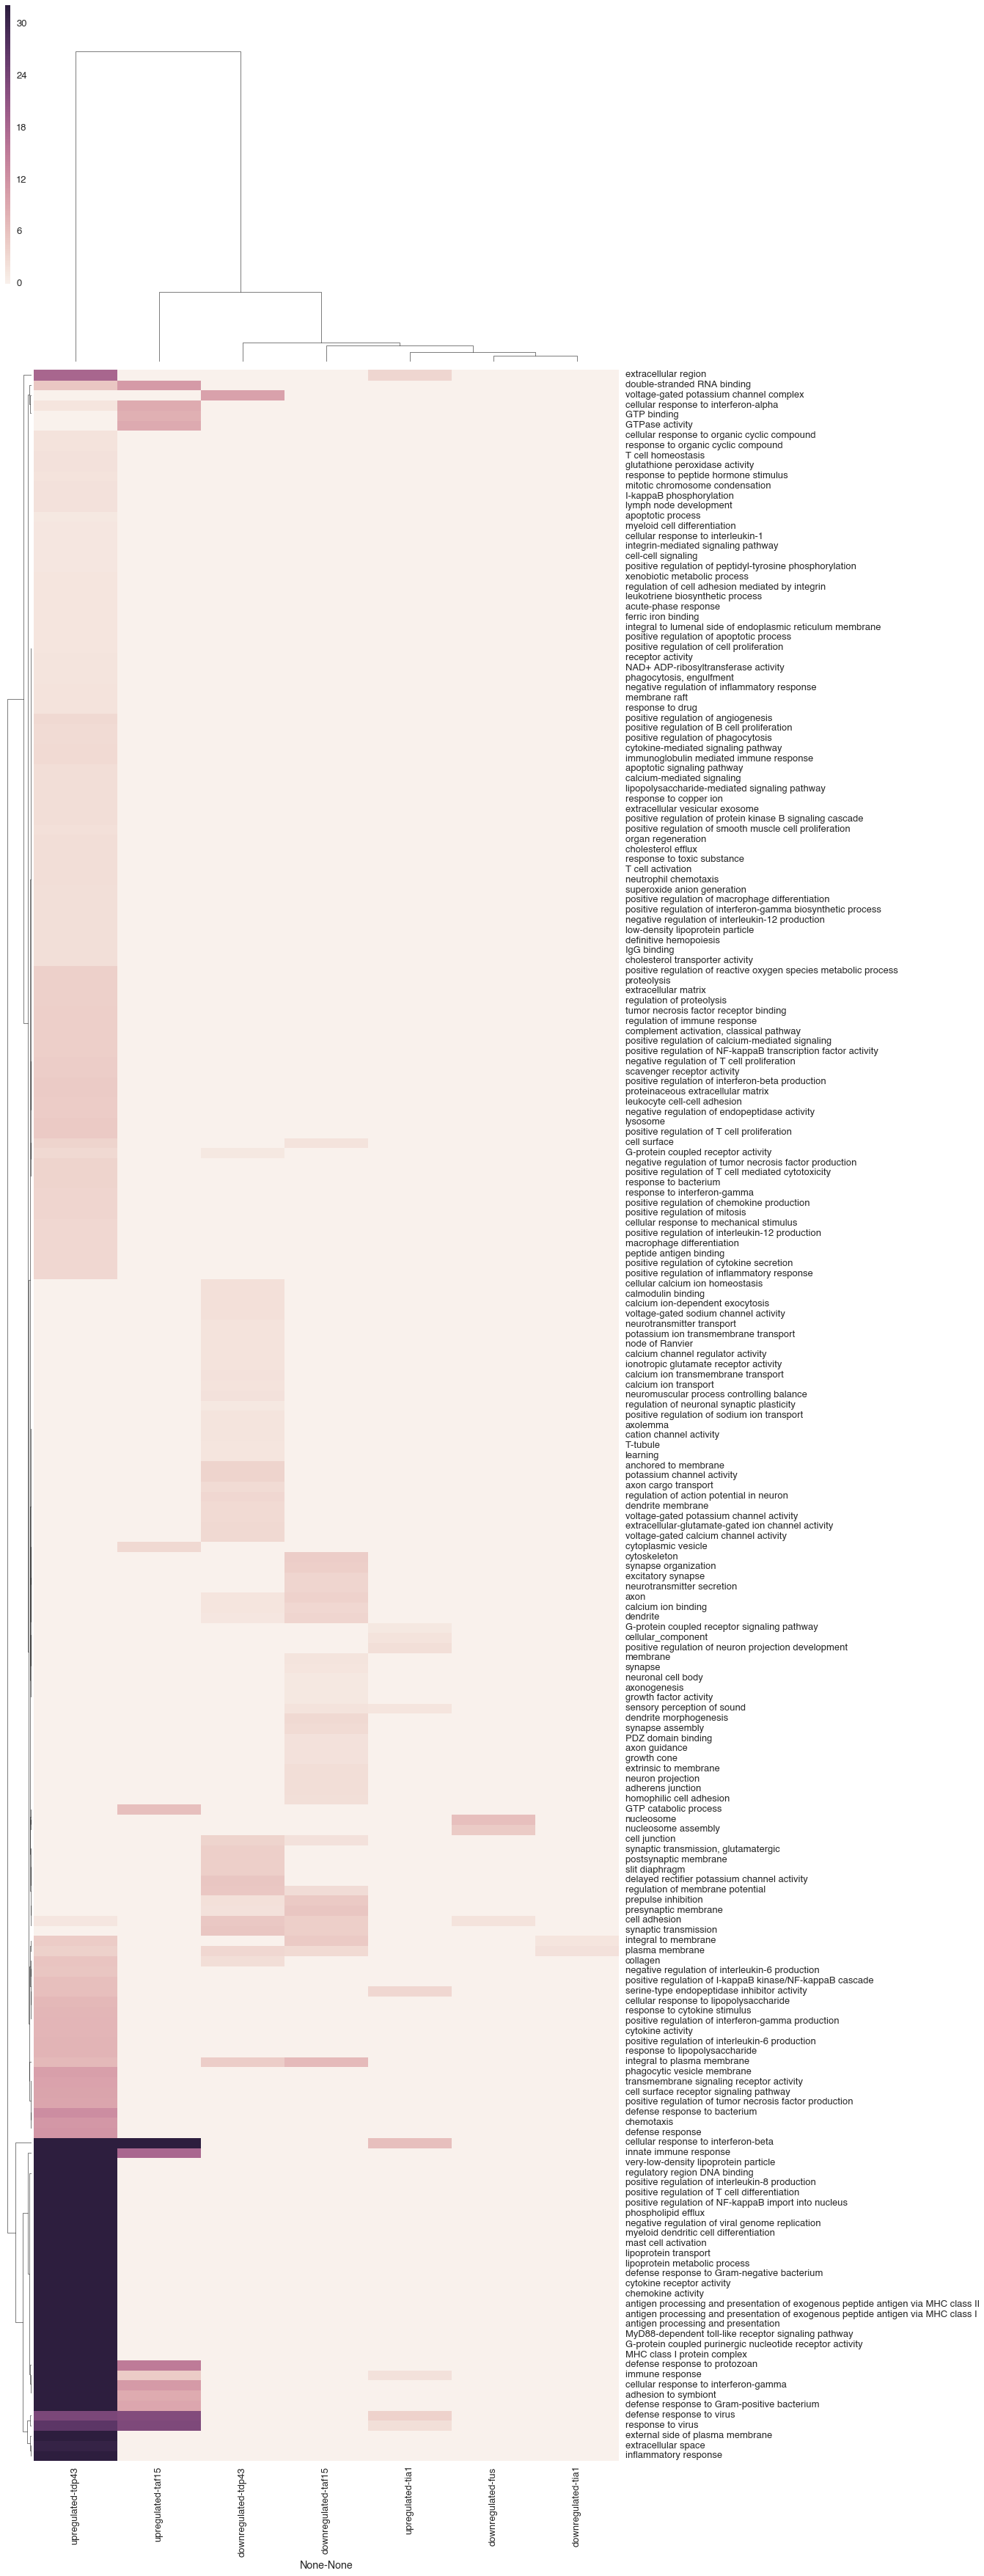

In [71]:
dataviz.plot_go_enrichment(all_go.xs("Straitum", level="cell_type"), figsize=(15,60)) 

Figure Legend: GO Enrichment for up and down regulated genes for all knockdowns in Straitum, TAF15, TIA1, TDP43 and FUS

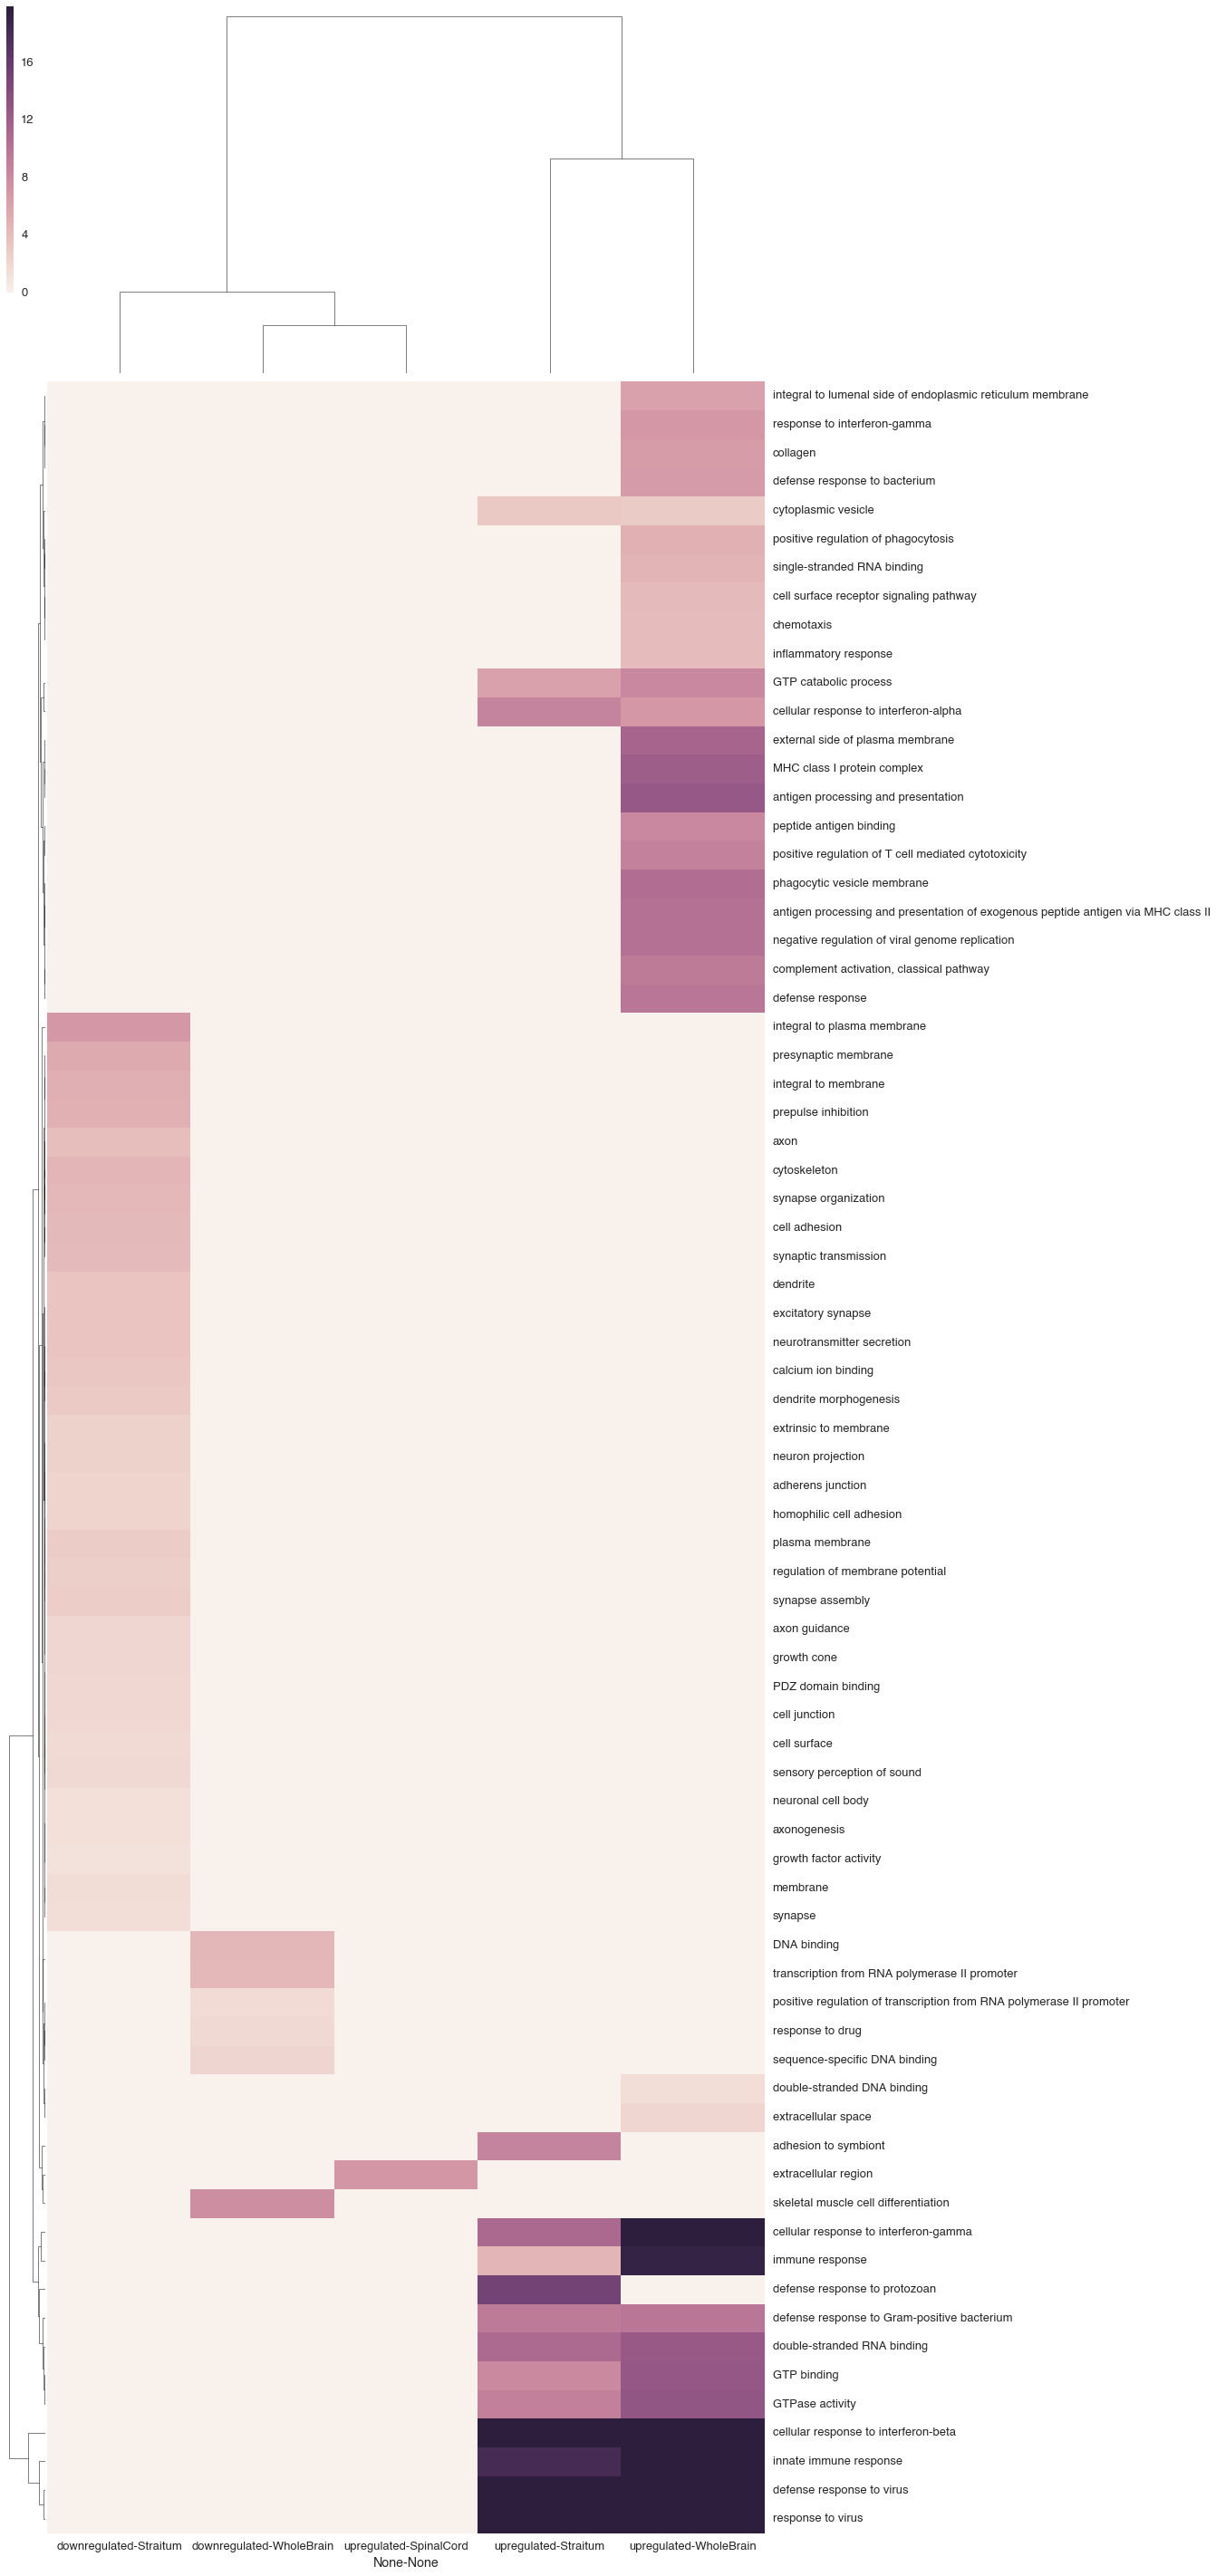

In [72]:
dataviz.plot_go_enrichment(all_go.xs("taf15", level="rbp"), figsize=(15,50)) 

Figure Legend: GO Enrichment for up and down regulated genes for TAF15 in Whole Brain, Spinal Cord and Straitum

#Gene Specific Analysis (ALS Specific)

In [73]:
name_to_gene_id_lower = {key.lower(): value for key, value in name_to_gene_id.items()}
als_specific_genes = pd.read_excel("/nas3/gpratt/Dropbox/TAF15/Data/als_specific_genes/Workbook1.xlsx", "Sheet1")

In [74]:
als_specific_genes = als_specific_genes.applymap(lambda x: x.lower())

In [75]:
als_specifc_gene_list = []
for als_gene in als_specific_genes['Gene symbol']:
    try:
        als_specifc_gene_list.append(name_to_gene_id_lower[als_gene])
    except KeyError:
        print als_gene

als3
als7
arhgef28
c1orf27
c9orf72
cyp2d6
diaph3
naip
rnase2
smn2
syne
znf746


In [76]:
significant_knockdowns[[gene_id in als_specifc_gene_list for gene_id in significant_knockdowns.index.get_level_values(level="geneid")]]

baseMean  log2FoldChange  \
rbp       cell_type  geneid                                                
ews       SpinalCord ENSMUSG00000000738.11   2084.761164        1.252460   
                     ENSMUSG00000002985.9   75805.516434        2.329206   
                     ENSMUSG00000004980.9    8155.191934       -0.910817   
                     ENSMUSG00000005089.8   65498.787471       -1.595128   
                     ENSMUSG00000006611.8     260.518957        1.037189   
                     ENSMUSG00000006818.4    4138.436450       -0.650301   
                     ENSMUSG00000009079.10   4117.166855       -0.861497   
                     ENSMUSG00000015837.9   15235.750037        0.878471   
                     ENSMUSG00000018293.3    3571.823239        1.525988   
                     ENSMUSG00000019647.9    3371.190037        0.693394   
                     ENSMUSG00000020115.2     941.320541       -0.940724   
                     ENSMUSG00000020128.8     686.696251       -1.932546   
                     ENSMUSG00000020467.8      94.155936       -0.727156   
                     ENSMUSG00000020848.7     428.103382        0.593508   
                     ENSMUSG00000021743.5       2.168509        1.789974   
                     ENSMUSG00000022280.8     984.412294       -0.666346   
                     ENSMUSG00000022982.9    5960.243050        1.413338   
                     ENSMUSG00000023064.4    3584.870836        1.319001   
                     ENSMUSG00000023484.7    2439.240492        1.356724   
                     ENSMUSG00000025232.6    1802.393539        1.276126   
                     ENSMUSG00000026024.8    1059.329489       -0.973853   
                     ENSMUSG00000026235.7    1200.336085       -1.549427   
                     ENSMUSG00000026585.7    6673.445127       -1.181207   
                     ENSMUSG00000026672.5     920.061200       -0.741628   
                     ENSMUSG00000026888.8     983.044631       -0.625550   
                     ENSMUSG00000026970.9    1004.977656       -0.842235   
                     ENSMUSG00000027365.8    1398.455356       -2.319338   
                     ENSMUSG00000027447.6   43023.919229        1.712029   
                     ENSMUSG00000027551.8     812.881924        1.499657   
                     ENSMUSG00000028393.4     990.775670        1.419801   
...                                                  ...             ...   
fus       Straitum   ENSMUSG00000020680.8    2794.041140        0.614600   
                     ENSMUSG00000030795.12   7291.420911       -3.331586   
                     ENSMUSG00000047037.5    1365.646872       -0.939302   
                     ENSMUSG00000054958.6      64.970484        0.691326   
                     ENSMUSG00000072115.4      64.644870        0.696729   
hnrnpa2b1 SpinalCord ENSMUSG00000004980.9    1104.034426       -1.950822   
hur       SpinalCord ENSMUSG00000042096.9     230.604065       -0.687171   
taf15     SpinalCord ENSMUSG00000020680.8    1481.251948       -4.138257   
          Straitum   ENSMUSG00000020396.7     685.889576       -0.650174   
                     ENSMUSG00000020680.8     651.314231       -2.730656   
                     ENSMUSG00000062209.8    1023.089233       -1.093860   
          WholeBrain ENSMUSG00000020396.7    2887.658081       -0.743995   
                     ENSMUSG00000020680.8     567.470635       -1.749803   
                     ENSMUSG00000024529.6      57.789402        0.833565   
tdp43     Straitum   ENSMUSG00000002985.9   47252.758141        0.738519   
                     ENSMUSG00000019647.9    1214.889736        0.631124   
                     ENSMUSG00000020396.7    1008.886829       -0.802674   
                     ENSMUSG00000022479.9      27.310551        1.028842   
                     ENSMUSG00000023951.9    1774.099057       -0.675229   
                     ENSMUSG00000025232.6    2309.423536        0.883213   
                    

#Miso Splicing Data

In [77]:
!mkdir -p /nas3/gpratt/projects/fet_family/analysis/fet_family_v2/miso/
!scp tscc-login1.sdsc.edu:/home/gpratt/projects/fet_family/analysis/fet_family_v2/miso/miso_diff_merged.csv /nas3/gpratt/projects/fet_family/analysis/fet_family_v2/miso/miso_diff_merged.csv

miso_diff_merged.csv                          100% 1438MB  28.8MB/s   00:50    


In [78]:
all_splicing_events = pd.read_csv("/nas3/gpratt/projects/fet_family/analysis/fet_family_v2/miso/miso_diff_merged.csv", index_col=[0,1,2])

new_index = []
factor_cashe = {}
for rbp, factor, event in all_splicing_events.index:
    if factor not in factor_cashe:
        splice_type = factor.split("_")[-1]

        rbp, control = factor.split("vs")
        control = "_".join(control.split("_")[:-1])
        rbp = biorep_info.ix[rbp]
        control = biorep_info.ix[control]
        rbp_rep = rbp.bio_rep
        rbp_name = rbp.rbp
        cell_type = rbp['Cell Type']
        control_rep = control.bio_rep

        factor_cashe[factor] = [rbp_name, rbp_rep, control_rep, cell_type, splice_type]

    index = copy.copy(factor_cashe[factor])
    index.append(event)

    new_index.append(index)
    
all_splicing_events.index = pd.MultiIndex.from_tuples(new_index, names=['rbp', 'rbp_rep', "control_rep", "cell_type", "splice_type", 'event'])

In [79]:
significant_splicing_events = all_splicing_events[(all_splicing_events.bayes_factor > 3) & (abs(all_splicing_events['diff']) > .25)]
inclusion_splicing_events = significant_splicing_events[significant_splicing_events['diff'] > 0]
exclusion_splicing_events = significant_splicing_events[significant_splicing_events['diff'] < 0]

In [80]:
HTML(pd.concat({"all": significant_splicing_events.groupby(level=['rbp', 'rbp_rep', 'control_rep', 'cell_type', 'splice_type']).count()['sample1_posterior_mean'],
            "included": inclusion_splicing_events.groupby(level=['rbp', 'rbp_rep', 'control_rep',  'cell_type', 'splice_type']).count()['sample1_posterior_mean'],
            "excluded": exclusion_splicing_events.groupby(level=['rbp', 'rbp_rep', 'control_rep',  'cell_type', 'splice_type']).count()['sample1_posterior_mean'],}).unstack(level=0).to_html())

In [81]:
inclusion_counts = inclusion_splicing_events.groupby(level=['rbp', 'splice_type', 'cell_type', 'event']).count()
exclusion_counts = exclusion_splicing_events.groupby(level=['rbp', 'splice_type', 'cell_type', 'event']).count()

In [82]:
confident_inclusion_events = []
for group, df in inclusion_counts.groupby(level=['rbp', 'cell_type']):
    rbp, cell_type = group
    rbp_rep_num = len(set(inclusion_splicing_events.xs([rbp, cell_type], level=['rbp', 'cell_type']).index.get_level_values(level="rbp_rep")))
    control_rep_num = len(set(inclusion_splicing_events.xs([rbp, cell_type], level=['rbp', 'cell_type']).index.get_level_values(level="control_rep")))
    possible_reps = rbp_rep_num * control_rep_num
    df = df[(df == possible_reps).sample1_posterior_mean]
    if len(df) != 0:
        confident_inclusion_events.append(df)
confident_inclusion_events = pd.concat(confident_inclusion_events)

In [83]:
confident_exclusion_events = []
for group, df in exclusion_counts.groupby(level=['rbp', 'cell_type']):
    rbp, cell_type = group
    rbp_rep_num = len(set(exclusion_splicing_events.xs([rbp, cell_type], level=['rbp', 'cell_type']).index.get_level_values(level="rbp_rep")))
    control_rep_num = len(set(exclusion_splicing_events.xs([rbp, cell_type], level=['rbp', 'cell_type']).index.get_level_values(level="control_rep")))
    possible_reps = rbp_rep_num * control_rep_num
    df = df[(df == possible_reps).sample1_posterior_mean]
    if len(df) != 0:
        confident_exclusion_events.append(df)
confident_exclusion_events = pd.concat(confident_exclusion_events)

In [84]:
any((df == possible_reps).sample1_posterior_mean)

False

In [85]:
confident_exclusion_events

sample1_posterior_mean  \
rbp   splice_type cell_type   event                                                                        
TAF15 A5SS        Whole Brain chr7:52961976:52962086|52962386:+@chr7:52963630...                       9   
      SE          Whole Brain chr10:80253356:80254306:+@chr10:80254888:802555...                       9   
                              chr19:7557429:7557779:-@chr19:7542301:7542357:-...                       9   
                              chr7:52960617:52961132:+@chr7:52961976:52962386...                       9   
TIA1  MXE         Striatum    chr11:90070298:90070360:+@chr11:90089349:900895...                       4   
      RI          Striatum    chr7:52632648-52632616:-@chr7:52632528-52631824:-                        4   
      SE          Striatum    chr12:72075610:72075754:+@chr12:72079720:720798...                       4   
                              chr12:72075610:72075754:+@chr12:72079720:720798...                       4   
                              chr2:35989655:35989783:-@chr2:35982735:35982771...                       4   
                              chr4:4065782:4065962:-@chr4:4065153:4065292:-@c...                       4   
                              chr4:4065782:4065962:-@chr4:4065153:4065293:-@c...                       4   
                              chr5:111085835:111085936:+@chr5:111086107:11108...                       4   
                              chr6:113328107:113328202:+@chr6:113330720:11333...                       4   

                                                                                  sample1_ci_low  \
rbp   splice_type cell_type   event                                                                
TAF15 A5SS        Whole Brain chr7:52961976:52962086|52962386:+@chr7:52963630...               9   
      SE          Whole Brain chr10:80253356:80254306:+@chr10:80254888:802555...               9   
                              chr19:7557429:7557779:-@chr19:7542301:7542357:-...               9   
                              chr7:52960617:52961132:+@chr7:52961976:52962386...               9   
TIA1  MXE         Striatum    chr11:90070298:90070360:+@chr11:90089349:900895...               4   
      RI          Striatum    chr7:52632648-52632616:-@chr7:52632528-52631824:-                4   
      SE          Striatum    chr12:72075610:72075754:+@chr12:72079720:720798...               4   
                              chr12:72075610:72075754:+@chr12:72079720:720798...               4   
                              chr2:35989655:35989783:-@chr2:35982735:35982771...               4   
                              chr4:4065782:4065962:-@chr4:4065153:4065292:-@c...               4   
                              chr4:4065782:4065962:-@chr4:4065153:4065293:-@c...               4   
                              chr5:111085835:111085936:+@chr5:111086107:11108...               4   
                              chr6:113328107:113328202:+@chr6:113330720:11333...               4   

                                                                                  sample1_ci_high  \
rbp   splice_type cell_type   event                                                                 
TAF15 A5SS        Whole Brain chr7:52961976:52962086|52962386:+@chr7:52963630...                9   
      SE          Whole Brain chr10:80253356:80254306:+@chr10:80254888:802555...                9   
                              chr19:7557429:7557779:-@chr19:7542301:7542357:-...                9   
                              chr7:52960617:52961132:+@chr7:52961976:52962386...                9   
TIA1  MXE         Striatum    chr11:90070298:90070360:+@chr11:90089349:900895...                4   
      RI          Striatum    chr7:52632648-52632616:-@chr7:52632528-52631824:-                 4   
      SE          Striatum    chr12:72075610:72075754:+@chr12:72079720:720798...                4   
                              chr12:72075610:720757

In [86]:
confident_inclusion_events

sample1_posterior_mean  \
rbp   splice_type cell_type event                                                                        
TDP43 SE          Striatum  chr3:108157051:108157159:+@chr3:108158390:10815...                      16   
TIA1  A3SS        Striatum  chr14:52695288:52695401:-@chr14:52695090|526951...                       4   
      A5SS        Striatum  chr4:106741217:106741428|106743152:+@chr4:10674...                       4   
                            chr4:147992900:147992756|147992774:-@chr4:14798...                       4   
      MXE         Striatum  chr3:36451528:36451673:+@chr3:36451957:36452051...                       4   
      SE          Striatum  chr10:115986089:115986231:-@chr10:115964883:115...                       4   
                            chr5:101225373:101226081:-@chr5:101221683:10122...                       4   

                                                                                sample1_ci_low  \
rbp   splice_type cell_type event                                                                
TDP43 SE          Striatum  chr3:108157051:108157159:+@chr3:108158390:10815...              16   
TIA1  A3SS        Striatum  chr14:52695288:52695401:-@chr14:52695090|526951...               4   
      A5SS        Striatum  chr4:106741217:106741428|106743152:+@chr4:10674...               4   
                            chr4:147992900:147992756|147992774:-@chr4:14798...               4   
      MXE         Striatum  chr3:36451528:36451673:+@chr3:36451957:36452051...               4   
      SE          Striatum  chr10:115986089:115986231:-@chr10:115964883:115...               4   
                            chr5:101225373:101226081:-@chr5:101221683:10122...               4   

                                                                                sample1_ci_high  \
rbp   splice_type cell_type event                                                                 
TDP43 SE          Striatum  chr3:108157051:108157159:+@chr3:108158390:10815...               16   
TIA1  A3SS        Striatum  chr14:52695288:52695401:-@chr14:52695090|526951...                4   
      A5SS        Striatum  chr4:106741217:106741428|106743152:+@chr4:10674...                4   
                            chr4:147992900:147992756|147992774:-@chr4:14798...                4   
      MXE         Striatum  chr3:36451528:36451673:+@chr3:36451957:36452051...                4   
      SE          Striatum  chr10:115986089:115986231:-@chr10:115964883:115...                4   
                            chr5:101225373:101226081:-@chr5:101221683:10122...                4   

                                                                                sample2_posterior_mean  \
rbp   splice_type cell_type event                                                                        
TDP43 SE          Striatum  chr3:108157051:108157159:+@chr3:108158390:10815...                      16   
TIA1  A3SS        Striatum  chr14:52695288:52695401:-@chr14:52695090|526951...                       4   
      A5SS        Striatum  chr4:106741217:106741428|106743152:+@chr4:10674...                       4   
                            chr4:147992900:147992756|147992774:-@chr4:14798...                       4   
      MXE         Striatum  chr3:36451528:36451673:+@chr3:36451957:36452051...                       4   
      SE          Striatum  chr10:115986089:115986231:-@chr10:115964883:115...                       4   
                            chr5:101225373:101226081:-@chr5:101221683:10122...                       4   

                                                                                sample2_ci_low  \
rbp   splice_type cell_type event                                                                
TDP43 SE          Striatum  chr3:108157051:108157159:+@chr3:108158390:10815...              16   
TIA1  A3SS        Striatum  chr14:52695288:52695401:-@chr14:52695090|526951...               4   
   

#Integrate Binding and Expression for Cytoscape

In [87]:
from clipper.src import CLIP_analysis

In [377]:
!scp /nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed tscc-login.sdsc.edu:/home/gpratt/projects/cryptic_exons/analysis/ad-hoc

TAF15_combined_notrim_ingenes_clusters_mm950. 100% 2887KB   2.8MB/s   00:00    


In [300]:
genes = pybedtools.BedTool("/nas3/gpratt/clipper/clipper/data/regions/mm9_genes.bed")


# rbps = {"taf15": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/analysis/mouse_clip_v5/TAF15_WholeBrain.merged.peaks.kasey.bed"),
#         'tdp43': pybedtools.BedTool("/nas3/gpratt/projects/fet_family/analysis/mouse_clip_v5/TDP43_WholeBrain.merged.peaks.kasey.bed"),
#         'fus': pybedtools.BedTool("/nas3/gpratt/projects/fet_family/analysis/mouse_clip_v5/TLS_WholeBrain.merged.peaks.kasey.bed"),}

rbps = {"taf15": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed"),
        "fus": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TLS_hiseq_notrim_ingenes_clusters_mm950.bed"),
        "tdp43": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TDP43brainclip_MP41_kcomb_notrim_ingenes_clusters_mm950.bed"),
 }

binding_df = []
assigned_peaks = {}
for name, rbp in rbps.items():
    overlapping_genes = rbp.intersect(genes, wo=True, s=True).each(move_name).saveas()

    cluster_regions = CLIP_analysis.assign_to_regions(overlapping_genes, name, 
                                    regions, "assigned", nrand=3, species="mm9")
    assigned_peaks[name] = cluster_regions
    for region in cluster_regions.keys():
        gene_names = pd.Series(Counter([interval.name.split(",")[0] for interval in cluster_regions[region]['real']]),
                                name=name + "_" + region)
        gene_names.name = (name, region)
        binding_df.append(gene_names)
binding_df = pd.concat(binding_df,axis=1)
binding_df.columns = pd.MultiIndex.from_tuples(binding_df.columns)
binding_df = binding_df.T
binding_df = binding_df.stack()
binding_df.index.names = ['rbp', 'region', 'gene_id']
binding_df = binding_df.sort_index()

There are a total 68407 clusters I'll examine
For region: cds found 313 that overlap and 68094 that don't
For region: three_prime_utrs found 2783 that overlap and 65311 that don't
For region: five_prime_utrs found 196 that overlap and 65115 that don't
For region: proxintron500 found 9222 that overlap and 55893 that don't
For region: distintron500 found 55824 that overlap and 69 that don't
After assigning 69 un-categorized regions
There are a total 2951 clusters I'll examine
For region: cds found 131 that overlap and 2820 that don't
For region: three_prime_utrs found 615 that overlap and 2205 that don't
For region: five_prime_utrs found 17 that overlap and 2188 that don't
For region: proxintron500 found 484 that overlap and 1704 that don't
For region: distintron500 found 1685 that overlap and 19 that don't
After assigning 19 un-categorized regions
There are a total 22412 clusters I'll examine
For region: cds found 2277 that overlap and 20135 that don't
For region: three_prime_utrs found

In [301]:
all_bound_genes = binding_df.swaplevel(0,1).ix['all']
all_bound_genes.index = pd.MultiIndex.from_tuples([(rbp, gene.split(".")[0]) for rbp, gene in all_bound_genes.index])


#Map Mouse to Human Genes

In [302]:
def map_to_mouse(gene):
    try:
        gene =  human_mouse_genes.ix[gene]["Ensembl Gene ID"]
        return gene[0] if type(gene) != str else gene
    except:
        return np.nan

In [303]:
mouse_human_genes = pd.read_table("/nas3/gpratt/projects/taf15/mouse_human_genes.txt", index_col=0)


In [304]:
#Show all fold changes by genes 

In [305]:
all_kds = significant_knockdowns.drop(["ews", 'tia1', 'hnrnpa2b1', 'hur']).log2FoldChange.unstack().fillna(0).T

In [306]:
clustering_kds = knockdowns.log2FoldChange.unstack()[all_kds.index].drop(["ews", 'tia1', 'hnrnpa2b1', 'hur']).T.fillna(0)

In [307]:
clustering_kds.index = [gene_id_to_name[gene_id] for gene_id in clustering_kds.index]

In [308]:
clustering_kds.to_csv(os.path.join(img_dir, "differental_expression.csv"))

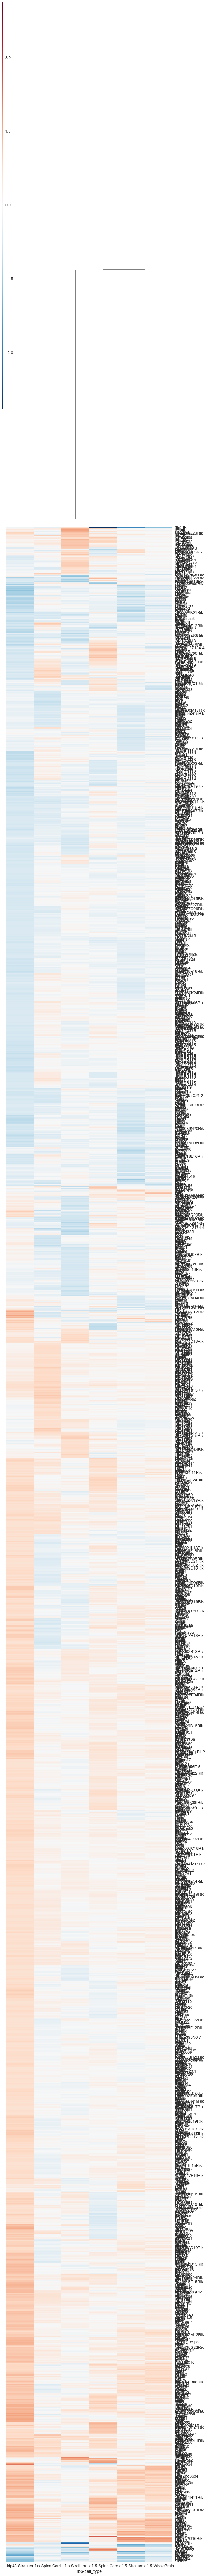

In [309]:
sns.clustermap(clustering_kds, linewidth=0, figsize=(10, 150))

#Create Network Analysis of bound and regulated genes

In [310]:
mouse_gene_id_names = pd.read_table("/nas3/gpratt/Dropbox/TAF15/Data/mouse_integration/mouse_gene_id_to_names.txt", index_col=0)
human_mouse_genes = pd.read_table("/nas3/gpratt/projects/taf15/mouse_human_genes.txt", index_col=2)

known_rbps = pd.read_excel("nrg3813-s3.xls", "RBP table", index_col=2)
known_tfs = pd.read_excel("nrg3813-s4.xls", "human TFs", index_col=1)

known_tfs['gene_id'] = known_tfs.index
known_rbps['gene_id'] = known_rbps.index

known_tfs['mouse_gene_id'] = known_tfs.gene_id.apply(map_to_mouse)
known_rbps['mouse_gene_id'] = known_rbps.gene_id.apply(map_to_mouse)

known_tfs = known_tfs.dropna()
known_rbps = known_rbps.dropna()

known_tfs.index = known_tfs.mouse_gene_id
known_rbps.index = known_rbps.mouse_gene_id

known_tfs = known_tfs.join(mouse_gene_id_names)
known_rbps = known_rbps.join(mouse_gene_id_names)

known_tfs = known_tfs.groupby(level=0).first()
known_rbps = known_rbps.groupby(level=0).first()

In [311]:
with open("/nas3/gpratt/Dropbox/TAF15/Data/networks/straitum_rbp_network.csv", 'w')as fn, open("/nas3/gpratt/Dropbox/TAF15/Data/networks/straitum_node_attributes.csv", 'w') as node_attributes:

    for name, df in signifcant_downregulated.xs(u'Straitum', level="cell_type").groupby(level=["rbp"]): 
        if name == "tia1":
            continue
        rbp_overlap = set(gencode_to_ensembl(df.index.get_level_values("geneid"))) & set(known_rbps.index)
        print name,  len(df.index), len(rbp_overlap) #rbp_overlap
        for gene in rbp_overlap:
            bound = "bound" if gene in all_bound_genes.ix[name] else "unbound"    
            node_attributes.write(",".join([mouse_gene_id_names.ix[gene][0], bound]) + "\n")
            fn.write(",".join([name, known_rbps.ix[gene]['gene name'], "downregulated", bound]) + "\n")
    print
    for name, df in signifcant_upregulated.xs(u'Straitum', level="cell_type").groupby(level=["rbp"]):
        if name == "tia1":
            continue
            
        rbp_overlap = set(gencode_to_ensembl(df.index.get_level_values("geneid"))) & set(known_rbps.index)
        print name,  len(df.index), len(rbp_overlap) #rbp_overlap
        for gene in rbp_overlap:
            bound = "bound" if gene in all_bound_genes.ix[name] else "unbound" 
            node_attributes.write(",".join([mouse_gene_id_names.ix[gene][0], bound]) + "\n")
            fn.write(",".join([name, known_rbps.ix[gene]['gene name'], "upregulated"]) + "\n")

fus 170 4
taf15 194 2
tdp43 646 9

fus 114 3
taf15 91 10
tdp43 1388 45


#Of the Co-differentall expressed RBPs how many of them actually overlap with binding sites?

In [312]:
protein_coding_genes = {key for key, value in gene_id_to_type.items() if value == "protein_coding"}

def fisher_exact_on_genes(regulated, bound, all_genes):

    not_regulated = protein_coding_genes - set(regulated)
    not_bound = protein_coding_genes - set(bound)

    bound_and_regulated = len(regulated & bound)
    bound_and_not_regulated = len(bound & not_regulated)
    not_bound_and_regulated = len(not_bound & regulated)
    not_bound_and_not_regulated = len(not_bound & not_regulated)

    
    counts = pd.Series({"bound_and_regulated": bound_and_regulated,
               "bound_and_not_regulated": bound_and_not_regulated,
               "not_bound_and_regulated": not_bound_and_regulated,
               "not_bound_and_not_regulated": not_bound_and_not_regulated,
               })
    
    test = scipy.stats.fisher_exact([[counts['bound_and_regulated'], counts['not_bound_and_regulated']], 
                                     [counts['bound_and_not_regulated'], counts['not_bound_and_not_regulated']]])
    
    counts['p_value'] = test[1]
    return counts

In [313]:
usable_rbps = ['fus', 'taf15', 'tdp43']
result = {}
upregulated_target_genes = {}
for regulated_name, df in signifcant_upregulated.ix[usable_rbps].xs("Straitum", level="cell_type").groupby(level=0):
    for bound_name in binding_df.index.levels[1]:
        regulated = set(df.ix[regulated_name].index) & protein_coding_genes
        bound = set(binding_df.ix[regulated_name, bound_name].index) & protein_coding_genes
        upregulated_target_genes[(regulated_name, bound_name)] = {gene_id: gene_id_to_name[gene_id] for gene_id in regulated & bound}
        counts = fisher_exact_on_genes(regulated, bound, protein_coding_genes)
        result[(regulated_name, bound_name)] = counts
        
upregulated_df = pd.DataFrame(result).T
upregulated_df['fraction_bound_and_regulated'] = upregulated_df.bound_and_regulated / (upregulated_df.bound_and_regulated + upregulated_df.not_bound_and_regulated)
upregulated_df['fraction_bound_and_not_regulated'] = upregulated_df.bound_and_not_regulated / (upregulated_df.bound_and_not_regulated + upregulated_df.not_bound_and_not_regulated)

In [314]:

usable_rbps = ['fus', 'taf15', 'tdp43']
result = {}
unchanging_target_genes = {}
for regulated_name, df in unchanging_knockdowns.ix[usable_rbps].xs("Straitum", level="cell_type").groupby(level=0):
    for bound_name in binding_df.index.levels[1]:
        regulated = set(df.ix[regulated_name].index) & protein_coding_genes
        bound = set(binding_df.ix[regulated_name, bound_name].index) & protein_coding_genes
        unchanging_target_genes[(regulated_name, bound_name)] = {gene_id: gene_id_to_name[gene_id] for gene_id in regulated & bound}
        counts = fisher_exact_on_genes(regulated, bound, protein_coding_genes)
        result[(regulated_name, bound_name)] = counts
        
unchanging_df = pd.DataFrame(result).T
unchanging_df['fraction_bound_and_regulated'] = unchanging_df.bound_and_regulated / (unchanging_df.bound_and_regulated + unchanging_df.not_bound_and_regulated)
unchanging_df['fraction_bound_and_not_regulated'] = unchanging_df.bound_and_not_regulated / (unchanging_df.bound_and_not_regulated + unchanging_df.not_bound_and_not_regulated)

In [315]:
usable_rbps = ['fus', 'taf15', 'tdp43']
result = {}
downregulated_target_genes = {}

for regulated_name, df in signifcant_downregulated.ix[usable_rbps].xs("Straitum", level="cell_type").groupby(level=0):
    for bound_name in binding_df.index.levels[1]:
        regulated = set(df.ix[regulated_name].index) & protein_coding_genes
        bound = set(binding_df.ix[regulated_name, bound_name].index) & protein_coding_genes
        downregulated_target_genes[(regulated_name, bound_name)] = {gene_id: gene_id_to_name[gene_id] for gene_id in regulated & bound}

        counts = fisher_exact_on_genes(regulated, bound, protein_coding_genes)
        result[(regulated_name, bound_name)] = counts

downregulated_df = pd.DataFrame(result).T
downregulated_df['fraction_bound_and_regulated'] = downregulated_df.bound_and_regulated / (downregulated_df.bound_and_regulated + downregulated_df.not_bound_and_regulated)
downregulated_df['fraction_bound_and_not_regulated'] = downregulated_df.bound_and_not_regulated / (downregulated_df.bound_and_not_regulated + downregulated_df.not_bound_and_not_regulated)

In [316]:
downregulated_df

bound_and_not_regulated  bound_and_regulated  \
fus   all                                   994                    9   
      cds                                   110                    2   
      distintron500                         526                    9   
      five_prime_utrs                        11                    0   
      proxintron500                         328                    3   
      three_prime_utrs                      317                    1   
      uncatagorized                           0                    0   
taf15 all                                  4173                  101   
      cds                                  1310                   18   
      distintron500                        2110                   79   
      five_prime_utrs                       133                    5   
      proxintron500                        1420                   39   
      three_prime_utrs                     1949                   43   
      uncatagorized                           3                    0   
tdp43 all                                  8436                  258   
      cds                                   232                   23   
      distintron500                        6830                  229   
      five_prime_utrs                       143                   11   
      proxintron500                        4374                  131   
      three_prime_utrs                     1340                   45   
      uncatagorized                           5                    1   

                        not_bound_and_not_regulated  not_bound_and_regulated  \
fus   all                                     21276                      101   
      cds                                     22160                      108   
      distintron500                           21744                      101   
      five_prime_utrs                         22259                      110   
      proxintron500                           21942                      107   
      three_prime_utrs                        21953                      109   
      uncatagorized                           22270                      110   
taf15 all                                     18016                       90   
      cds                                     20879                      173   
      distintron500                           20079                      112   
      five_prime_utrs                         22056                      186   
      proxintron500                           20769                      152   
      three_prime_utrs                        20240                      148   
      uncatagorized                           22186                      191   
tdp43 all                                     13516                      170   
      cds                                     21720                      405   
      distintron500                           15122                      199   
      five_prime_utrs                         21809                      417   
      proxintron500                           17578                      297   
      three_prime_utrs                        20612                      383   
      uncatagorized                           21947                      427   

                             p_value  fraction_bound_and_regulated  \
fus   all               6.513516e-02                      0.081818   
      cds               1.051674e-01                      0.018182   
      distintron500     1.306553e-03                      0.081818   
      five_prime_utrs   1.000000e+00                      0.000000   
      proxintron500     2.226334e-01                      0.027273   
      three_prime_utrs  1.000000e+00                      0.009091   
      uncatagorized     1.000000e+00                      0.000000   
taf15 all               1.132586e-25                      0.528796   
      cds               4.550944e-02            

In [317]:
downregulated_df.p_value = downregulated_df.p_value * len(downregulated_df.p_value)
upregulated_df.p_value = upregulated_df.p_value * len(upregulated_df.p_value)
unchanging_df.p_value = unchanging_df.p_value * len(upregulated_df.p_value)


downregulated_df = downregulated_df.drop("uncatagorized", level=1)
upregulated_df = upregulated_df.drop("uncatagorized", level=1)
unchanging_df = unchanging_df.drop("uncatagorized", level=1)

downregulated_df['percent_bound_and_regulated'] = downregulated_df['fraction_bound_and_regulated'] * 100
downregulated_df['percent_bound_and_not_regulated'] = downregulated_df['fraction_bound_and_not_regulated'] * 100

upregulated_df['percent_bound_and_regulated'] = upregulated_df['fraction_bound_and_regulated'] * 100
upregulated_df['percent_bound_and_not_regulated'] = upregulated_df['fraction_bound_and_not_regulated'] * 100

unchanging_df['percent_bound_and_regulated'] = unchanging_df['fraction_bound_and_regulated'] * 100
unchanging_df['percent_bound_and_not_regulated'] = unchanging_df['fraction_bound_and_not_regulated'] * 100

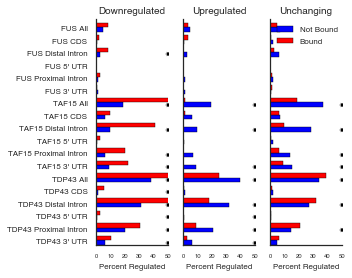

In [318]:
values = downregulated_df.percent_bound_and_regulated.values
ind = np.arange(len(values))
width = 0.35


with dataviz.Figure(os.path.join(img_dir, "binding_and_regulation_analysis.svg"), figsize=(5,4)) as fig:
    ax = fig.add_subplot(1,3, 1)
    ax.barh(ind, list(reversed(list(downregulated_df.percent_bound_and_not_regulated))), 
            width, color='b', label="Not Bound")
    ax.barh(ind + width, list(reversed(list(values))), width, color='r', label="Bound")
    
    scatter_locs = [(50, y + (width / 2)) for y, significant in enumerate(reversed(list(downregulated_df.p_value < .05))) if significant]
    scatter_x = [x for x,y in scatter_locs]
    scatter_y = [y for x,y in scatter_locs]
    ax.scatter(scatter_x, scatter_y, marker=(6, 2, 30), color='k')
    
    ax.set_title("Downregulated", fontsize=10)
    ax.set_xlabel("Percent Regulated", fontsize=8)
    ax.set_yticks(ind + (width / 2))
    #ax.set_yticklabels(list(reversed([rbp_names[item] for item in upregulated_df.index])), fontsize=8)
    ax.set_yticklabels(list(reversed([" ".join([rbp_names[item[0]], all_regions[item[1]].replace("\n", " ")]) for item in upregulated_df.index])), fontsize=8)

    [tick.set_fontsize(6) for tick in ax.get_xticklabels()]
    ax.set_xlim(0, 50)
    ax.set_ylim(0, len(values))
    sns.despine(ax=ax)

    ax = fig.add_subplot(1,3,2)
    values = upregulated_df.percent_bound_and_regulated.values

    ax.barh(ind, list(reversed(list(upregulated_df.percent_bound_and_not_regulated))), 
            width, color='b', label="Not Bound")
    ax.barh(ind + width, list(reversed(list(values))), width, color='r', label="Bound")
    
    scatter_locs = [(50, y + (width / 2)) for y, significant in enumerate(reversed(list(upregulated_df.p_value < .05))) if significant]
    scatter_x = [x for x,y in scatter_locs]
    scatter_y = [y for x,y in scatter_locs]
    ax.scatter(scatter_x, scatter_y, marker=(6, 2, 30), color='k')
    
    ax.set_title("Upregulated", fontsize=10)
    ax.set_xlabel("Percent Regulated", fontsize=8)
    ax.set_yticklabels([])
    [tick.set_fontsize(6) for tick in ax.get_xticklabels()]
    ax.set_xlim(0, 50)
    ax.set_ylim(0, len(values))
    #ax.legend(loc=0, fontsize=8)
    sns.despine(ax=ax)
    
    ax = fig.add_subplot(1,3, 3)
    values = unchanging_df.percent_bound_and_regulated.values

    ax.barh(ind, list(reversed(list(unchanging_df.percent_bound_and_not_regulated))), 
            width, color='b', label="Not Bound")
    ax.barh(ind + width, list(reversed(list(values))), width, color='r', label="Bound")
    
    scatter_locs = [(50, y + (width / 2)) for y, significant in enumerate(reversed(list(unchanging_df.p_value < .05))) if significant]
    scatter_x = [x for x,y in scatter_locs]
    scatter_y = [y for x,y in scatter_locs]
    ax.scatter(scatter_x, scatter_y, marker=(6, 2, 30), color='k')
    
    ax.set_title("Unchanging", fontsize=10)
    ax.set_xlabel("Percent Regulated", fontsize=8)
    ax.set_yticklabels([])
    [tick.set_fontsize(6) for tick in ax.get_xticklabels()]
    ax.set_xlim(0, 50)
    ax.set_ylim(0, len(values))
    ax.legend(loc=0, fontsize=8)
    sns.despine(ax=ax)



In [371]:
img_dir

'/nas3/gpratt/Dropbox/TAF15/Data/mouse_integration'

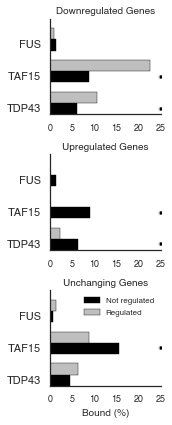

In [369]:
downregulated_all_df = downregulated_df.xs('three_prime_utrs', level=1)
upregulated_all_df = upregulated_df.xs('three_prime_utrs', level=1)
unchanging_all_df = unchanging_df.xs('three_prime_utrs', level=1)

values = downregulated_all_df.percent_bound_and_regulated.values
ind = np.arange(len(values))
width = 0.35
num_rows = 3
num_cols = 1
target_color = 'k'
non_target_color = '.75'
max_percent = 25
with dataviz.Figure(os.path.join(img_dir, "binding_and_regulation_analysis_only_three_prime_utrs.svg"), figsize=(2.5 * num_cols, 2.0 * num_rows)) as fig:
    ax = fig.add_subplot(num_rows, num_cols, 1)
    ax.barh(ind, list(reversed(list(downregulated_all_df.percent_bound_and_not_regulated))), 
            width, color=target_color, label="Not Bound")
    ax.barh(ind + width, list(reversed(list(values))), width, color=non_target_color, label="non target")
    
    scatter_locs = [(max_percent, y + (width / 2)) for y, significant in enumerate(reversed(list(downregulated_all_df.p_value < .05))) if significant]
    scatter_x = [x for x,y in scatter_locs]
    scatter_y = [y for x,y in scatter_locs]
    ax.scatter(scatter_x, scatter_y, marker=(6, 2, 30), color='k')
    
    ax.set_title("Downregulated Genes", fontsize=10)
    #ax.set_xlabel("Regulated (%)", fontsize=10)
    ax.set_yticks(ind + (width / 2))
    ax.set_yticklabels(list(reversed([rbp_names[item] for item in upregulated_all_df.index])), fontsize=11)

    [tick.set_fontsize(9) for tick in ax.get_xticklabels()]
    ax.set_xlim(0, max_percent)
    ax.set_ylim(0, len(values))
    sns.despine(ax=ax)

    ax = fig.add_subplot(num_rows, num_cols, 2)
    values = upregulated_all_df.percent_bound_and_regulated.values

    ax.barh(ind, list(reversed(list(upregulated_all_df.percent_bound_and_not_regulated))), 
            width, color=target_color, label="Not Bound")
    ax.barh(ind + width, list(reversed(list(values))), width, color=non_target_color, label="target")
    
    scatter_locs = [(max_percent, y + (width / 2)) for y, significant in enumerate(reversed(list(upregulated_all_df.p_value < .05))) if significant]
    scatter_x = [x for x,y in scatter_locs]
    scatter_y = [y for x,y in scatter_locs]
    ax.scatter(scatter_x, scatter_y, marker=(6, 2, 30), color='k')
    
    ax.set_title("Upregulated Genes", fontsize=10)
    #ax.set_xlabel("Regulated (%)", fontsize=10)
    ax.set_yticks(ind + (width / 2))
    ax.set_yticklabels(list(reversed([rbp_names[item] for item in upregulated_all_df.index])), fontsize=11)
    [tick.set_fontsize(9) for tick in ax.get_xticklabels()]
    ax.set_xlim(0, max_percent)
    ax.set_ylim(0, len(values))
    sns.despine(ax=ax)
    
    ax = fig.add_subplot(num_rows, num_cols, 3)
    values = unchanging_all_df.percent_bound_and_regulated.values

    ax.barh(ind, list(reversed(list(unchanging_all_df.percent_bound_and_not_regulated))), 
            width, color=target_color, label="Not regulated")
    ax.barh(ind + width, list(reversed(list(values))), width, color=non_target_color, label="Regulated")
    
    scatter_locs = [(max_percent, y + (width / 2)) for y, significant in enumerate(reversed(list(unchanging_all_df.p_value < .05))) if significant]
    scatter_x = [x for x,y in scatter_locs]
    scatter_y = [y for x,y in scatter_locs]
    ax.scatter(scatter_x, scatter_y, marker=(6, 2, 30), color='k')
    
    ax.set_title("Unchanging Genes", fontsize=10)
    ax.set_xlabel("Bound (%)", fontsize=10)
    ax.set_yticks(ind + (width / 2))
    ax.set_yticklabels(list(reversed([rbp_names[item] for item in upregulated_all_df.index])), fontsize=11)
    [tick.set_fontsize(9) for tick in ax.get_xticklabels()]
    ax.set_xlim(0, max_percent)
    ax.set_ylim(0, len(values))
    ax.legend(loc=0, fontsize=8)
    sns.despine(ax=ax)

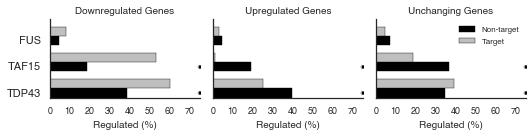

In [370]:
downregulated_all_df = downregulated_df.xs('all', level=1)
upregulated_all_df = upregulated_df.xs('all', level=1)
unchanging_all_df = unchanging_df.xs('all', level=1)

values = downregulated_all_df.percent_bound_and_regulated.values
ind = np.arange(len(values))
width = 0.35
num_rows = 1
num_cols = 3
target_color = 'k'
non_target_color = '.75'
max_percent = 75
with dataviz.Figure(os.path.join(img_dir, "binding_and_regulation_analysis_only_all.svg"), figsize=(2.5 * num_cols, 2.0 * num_rows)) as fig:
    ax = fig.add_subplot(num_rows, num_cols, 1)
    ax.barh(ind, list(reversed(list(downregulated_all_df.percent_bound_and_not_regulated))), 
            width, color=target_color, label="Not Bound")
    ax.barh(ind + width, list(reversed(list(values))), width, color=non_target_color, label="non target")
    
    scatter_locs = [(max_percent, y + (width / 2)) for y, significant in enumerate(reversed(list(downregulated_all_df.p_value < .05))) if significant]
    scatter_x = [x for x,y in scatter_locs]
    scatter_y = [y for x,y in scatter_locs]
    ax.scatter(scatter_x, scatter_y, marker=(6, 2, 30), color='k')
    
    ax.set_title("Downregulated Genes", fontsize=10)
    ax.set_xlabel("Regulated (%)", fontsize=10)
    ax.set_yticks(ind + (width / 2))
    ax.set_yticklabels(list(reversed([rbp_names[item] for item in upregulated_all_df.index])), fontsize=11)

    [tick.set_fontsize(9) for tick in ax.get_xticklabels()]
    ax.set_xlim(0, max_percent)
    ax.set_ylim(0, len(values))
    sns.despine(ax=ax)

    ax = fig.add_subplot(num_rows, num_cols, 2)
    values = upregulated_all_df.percent_bound_and_regulated.values

    ax.barh(ind, list(reversed(list(upregulated_all_df.percent_bound_and_not_regulated))), 
            width, color=target_color, label="Not Bound")
    ax.barh(ind + width, list(reversed(list(values))), width, color=non_target_color, label="target")
    
    scatter_locs = [(max_percent, y + (width / 2)) for y, significant in enumerate(reversed(list(upregulated_all_df.p_value < .05))) if significant]
    scatter_x = [x for x,y in scatter_locs]
    scatter_y = [y for x,y in scatter_locs]
    ax.scatter(scatter_x, scatter_y, marker=(6, 2, 30), color='k')
    
    ax.set_title("Upregulated Genes", fontsize=10)
    ax.set_xlabel("Regulated (%)", fontsize=10)
    ax.set_yticklabels([])
    [tick.set_fontsize(9) for tick in ax.get_xticklabels()]
    ax.set_xlim(0, max_percent)
    ax.set_ylim(0, len(values))
    sns.despine(ax=ax)
    
    ax = fig.add_subplot(num_rows, num_cols, 3)
    values = unchanging_all_df.percent_bound_and_regulated.values

    ax.barh(ind, list(reversed(list(unchanging_all_df.percent_bound_and_not_regulated))), 
            width, color=target_color, label="Non-target")
    ax.barh(ind + width, list(reversed(list(values))), width, color=non_target_color, label="Target")
    
    scatter_locs = [(max_percent, y + (width / 2)) for y, significant in enumerate(reversed(list(unchanging_all_df.p_value < .05))) if significant]
    scatter_x = [x for x,y in scatter_locs]
    scatter_y = [y for x,y in scatter_locs]
    ax.scatter(scatter_x, scatter_y, marker=(6, 2, 30), color='k')
    
    ax.set_title("Unchanging Genes", fontsize=10)
    ax.set_xlabel("Regulated (%)", fontsize=10)
    ax.set_yticklabels([])
    [tick.set_fontsize(9) for tick in ax.get_xticklabels()]
    ax.set_xlim(0, max_percent)
    ax.set_ylim(0, len(values))
    ax.legend(loc=0, fontsize=8)
    sns.despine(ax=ax)

In [321]:
downregulated_all_df

bound_and_not_regulated  bound_and_regulated  \
fus                        994                    9   
taf15                     4173                  101   
tdp43                     8436                  258   

       not_bound_and_not_regulated  not_bound_and_regulated       p_value  \
fus                          21276                      101  1.367838e+00   
taf15                        18016                       90  2.378431e-24   
tdp43                        13516                      170  4.503382e-18   

       fraction_bound_and_regulated  fraction_bound_and_not_regulated  \
fus                        0.081818                          0.044634   
taf15                      0.528796                          0.188066   
tdp43                      0.602804                          0.384293   

       percent_bound_and_regulated  percent_bound_and_not_regulated  
fus                       8.181818                         4.463404  
taf15                    52.879581                        18.806616  
tdp43                    60.280374                        38.429300

In [322]:
upregulated_all_df

bound_and_not_regulated  bound_and_regulated  \
fus                       1002                    1   
taf15                     4273                    1   
tdp43                     8392                  302   

       not_bound_and_not_regulated  not_bound_and_regulated       p_value  \
fus                          21348                       29  2.100000e+01   
taf15                        18021                       85  1.153263e-05   
tdp43                        12789                      897  2.763675e-23   

       fraction_bound_and_regulated  fraction_bound_and_not_regulated  \
fus                        0.033333                          0.044832   
taf15                      0.011628                          0.191666   
tdp43                      0.251877                          0.396204   

       percent_bound_and_regulated  percent_bound_and_not_regulated  
fus                       3.333333                         4.483221  
taf15                     1.162791                        19.166592  
tdp43                    25.187656                        39.620415

In [323]:
unchanging_all_df

bound_and_not_regulated  bound_and_regulated  \
fus                         10                  993   
taf15                      102                 4172   
tdp43                      560                 8134   

       not_bound_and_not_regulated  not_bound_and_regulated       p_value  \
fus                            130                    21247  3.051237e+00   
taf15                          175                    17931  9.470215e-11   
tdp43                         1067                    12619  2.971974e-03   

       fraction_bound_and_regulated  fraction_bound_and_not_regulated  \
fus                        0.044649                          0.071429   
taf15                      0.188753                          0.368231   
tdp43                      0.391943                          0.344192   

       percent_bound_and_regulated  percent_bound_and_not_regulated  
fus                       4.464928                         7.142857  
taf15                    18.875266                        36.823105  
tdp43                    39.194333                        34.419176

#Get the actual genes that are bound and regulated, do go analysis, maybe print out the actual genes

In [324]:
def bound_and_regulated_regions(df):
    df = pd.DataFrame(pd.DataFrame(df).T.stack())
    df['region'] = df.index.get_level_values(level=1)
    combined = df.region.swaplevel(1,2).unstack().apply(lambda x: ",".join(x.dropna()), axis=1)
    df.index = df.index.droplevel(1)
    df['index'] = df.index 
    df = df.drop_duplicates(subset='index', take_last=True)
    df['merged_regions'] = combined
    df = df.drop(['region', 'index'], axis=1)
    return df

In [325]:
df = bound_and_regulated_regions(downregulated_target_genes)
df.to_csv("/nas3/gpratt/Dropbox/TAF15/Data/mouse_integration/downregulated_bound_and_regulated.csv")
HTML(df.to_html())

/nas/nas0/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: the take_last=True keyword is deprecated, use keep='last' instead


In [372]:
df = bound_and_regulated_regions(upregulated_target_genes)
df.to_csv("/nas3/gpratt/Dropbox/TAF15/Data/mouse_integration/upregulated_bound_and_regulated.csv")

/nas/nas0/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: the take_last=True keyword is deprecated, use keep='last' instead


In [327]:
#Do the expressed gene background
downregulated_bound_and_regulated_go = {}
for name, series in downregulated_target_genes.items():
    downregulated_bound_and_regulated_go[name] = mm9go.enrichment(gencode_to_ensembl(series))
downregulated_bound_and_regulated_go = pd.concat(downregulated_bound_and_regulated_go, names=["rbp", 'cell_type', "GO Term ID"]).dropna()

upregulated_bound_and_regulated_go = {}
for name, series in upregulated_target_genes.items():
    upregulated_bound_and_regulated_go[name] = mm9go.enrichment(gencode_to_ensembl(series))
upregulated_bound_and_regulated_go = pd.concat(upregulated_bound_and_regulated_go, names=["rbp", 'cell_type', "GO Term ID"]).dropna()


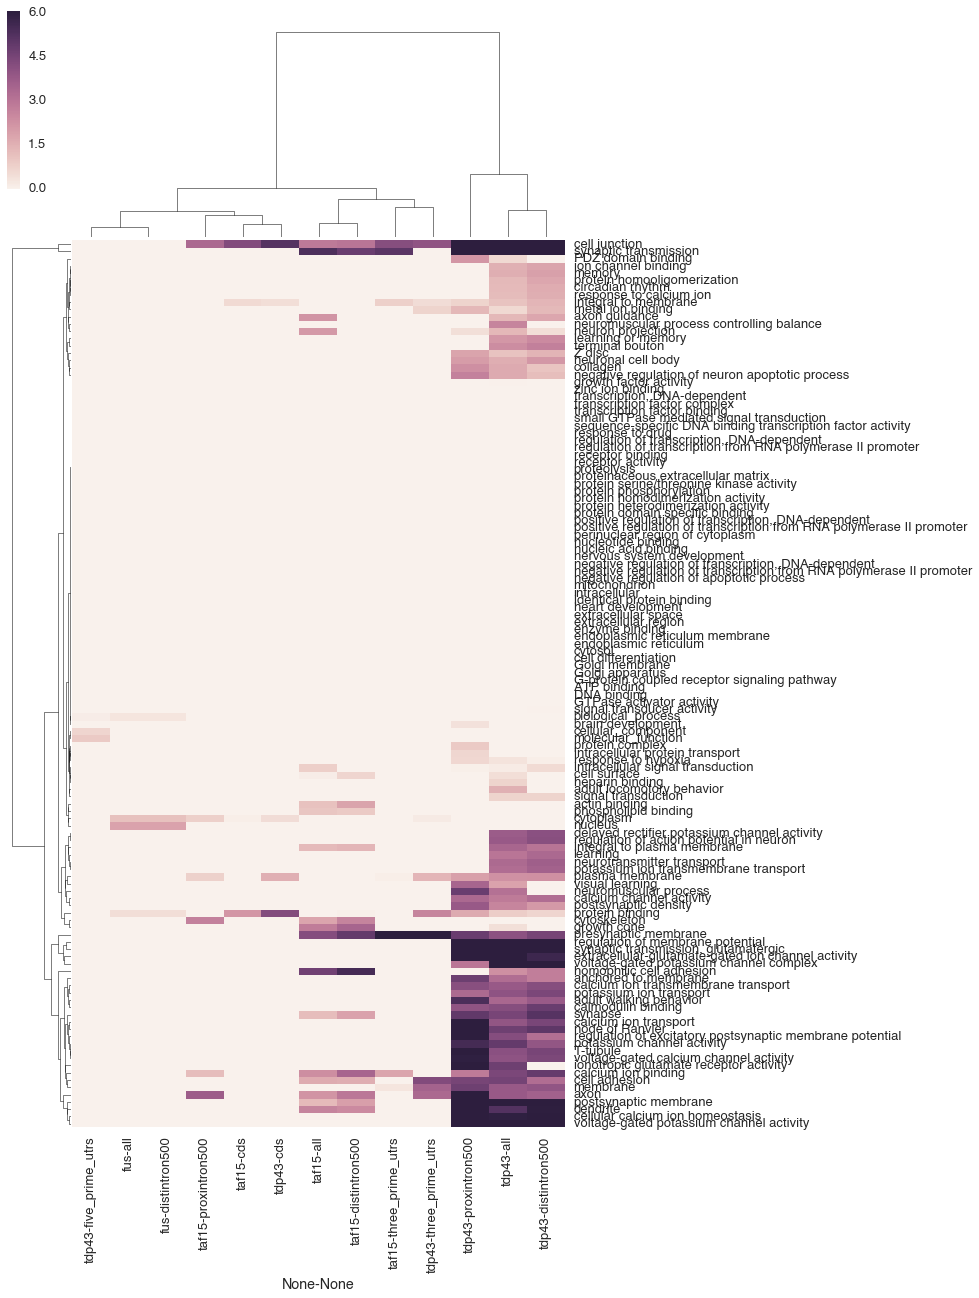

In [328]:
#cool polish this up a bit and maybe include
dataviz.plot_go_enrichment(downregulated_bound_and_regulated_go, figsize=(10,20))

#Are genes that are bound and downregulated by taf15 and TDP43 overlapping? What about FUS?

In [329]:
regulated = signifcant_downregulated.ix[usable_rbps].xs("Straitum", level="cell_type").groupby(level=0)

In [330]:
taf15_bound = set(binding_df.ix['taf15', 'all'].index) & protein_coding_genes
taf15_regulated = set(regulated.get_group("taf15").index.get_level_values(level=1)) & protein_coding_genes

fus_bound = set(binding_df.ix['fus', 'all'].index) & protein_coding_genes
fus_regulated = set(regulated.get_group("fus").index.get_level_values(level=1)) & protein_coding_genes

tdp43_bound = set(binding_df.ix['tdp43', 'all'].index) & protein_coding_genes
tdp43_regulated = set(regulated.get_group("tdp43").index.get_level_values(level=1)) & protein_coding_genes

taf15_bound_and_regulated = taf15_bound & taf15_regulated
fus_bound_and_regulated = fus_bound & fus_regulated
tdp43_bound_and_regulated = tdp43_bound & tdp43_regulated

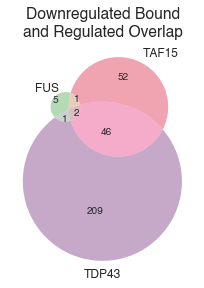

In [331]:
with dataviz.Figure(os.path.join(img_dir, "venn_binding_and_regulation_analysis_only_all.svg"), figsize=(4,4)) as fig:
    ax = fig.add_subplot(1,1,1)
    venn3([fus_bound_and_regulated, taf15_bound_and_regulated, tdp43_bound_and_regulated],
         set_labels=['FUS', 'TAF15', 'TDP43'],
         set_colors=[rbp_colors['fus'], rbp_colors['taf15'], rbp_colors['tdp43']], 
          ax=ax)
    ax.set_title("Downregulated Bound\nand Regulated Overlap")
    

There is a pretty good overlap bewteen bound and regulated genes for TAF15 and TDP43

#Motif Presence / Absence in peaks

In [332]:
CLIP_analysis.make_fasta_files_from_regions(assigned_peaks['fus'], 
                                            'fus', 
                                            "fasta", 
                                            "/nas3/yeolab/Genome/ucsc/mm9/chromosomes/all.fa")

CLIP_analysis.make_fasta_files_from_regions(assigned_peaks['taf15'], 
                                            'taf15', 
                                            "fasta", 
                                            "/nas3/yeolab/Genome/ucsc/mm9/chromosomes/all.fa")

CLIP_analysis.make_fasta_files_from_regions(assigned_peaks['tdp43'], 
                                            'tdp43', 
                                            "fasta", 
                                            "/nas3/yeolab/Genome/ucsc/mm9/chromosomes/all.fa")

In [333]:
def findMotifs(fasta, motif):
        

    """
    
    runs homer with standard args
    output location is saved
    
    foreground - str, location of fasta file for the foreground distribution
    background - str, location of fasta file for the background distribution
    k - different k-mers to examine
    outloc - directory to output homer results 

    --make optional make work off locations and not fasta files 
    
    """
    #findMotifs.pl clusters.fa fasta outloc -nofacts p 4 -rna -S 10 -len 5,6,7,8,9 -noconvert -nogo -fasta background.fa
    #converts k to a string for use in subprocess
    handle, tmp_file = tempfile.mkstemp()
    with open(tmp_file, 'w') as handle:
        try:
            subprocess.call(["findMotifs.pl",
                             fasta,
                             "fasta",
                             "motifResults",
                             "-find", motif,
                             "-rna"], shell=False, stdout=handle
                           )

        except OSError:
            print "Homer not installed, ignoring motif generation, install homer for this to work"  
            raise
    return pd.read_table(tmp_file, index_col=0)

In [334]:
for rbp in assigned_peaks:
    print len(assigned_peaks[rbp]['all']['real'])

68338
2932
22329


In [335]:
all_motif1_file = "/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/all/homerResults/motif1.motif"
#all_motif1_target, all_motif1_background, all_motif1_pvalue = get_homer_values(all_motif1_file)

utr3_motif1_file = "/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/three_prime_utrs/homerResults/motif1.motif"
#utr3_motif1_target, utr3_motif1_background, utr3_motif1_pvalue = get_homer_values(utr3_motif1_file)

all_motif2_file = "/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/all/homerResults/motif2.motif"
#all_motif2_target, all_motif2_background, all_motif2_pvalue = get_homer_values(all_motif2_file)

utr3_motif2_file = "/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/three_prime_utrs/homerResults/motif2.motif"
#utr3_motif2_target, utr3_motif2_background, utr3_motif2_pvalue = get_homer_values(utr3_motif2_file)

In [336]:
#"GGTAAG.motif"
#"TCGGTGGT.motif"
result = {}
for rbp in assigned_peaks:
    for region in assigned_peaks[rbp]:
        print rbp, region
        print "fasta/{}.{}.{}.fa".format(rbp, region, 'real')
        try:
            motifs_in_peaks = findMotifs("fasta/{}.{}.{}.fa".format(rbp, region, 'real'), all_motif2_file)
            result[(rbp, region, "real", "GGTAAG")] = {"peaks_with_motif": len(motifs_in_peaks.index.drop_duplicates()),
                                             "total_peaks": len(assigned_peaks[rbp][region]['real'])
                                             }

            motifs_in_peaks = findMotifs("fasta/{}.{}.{}.fa".format(rbp, region, 'random'), all_motif2_file)
            total_peaks = sum(len(bedtool) for bedtool in assigned_peaks[rbp][region]['rand'].values())
            result[(rbp, region, "random", "GGTAAG")] = {"peaks_with_motif": len(motifs_in_peaks.index.drop_duplicates()),
                                             "total_peaks": total_peaks
                                             }
            
            motifs_in_peaks = findMotifs("fasta/{}.{}.{}.fa".format(rbp, region, 'real'), utr3_motif2_file)
            result[(rbp, region, "real", "TCGGTGGT")] = {"peaks_with_motif": len(motifs_in_peaks.index.drop_duplicates()),
                                             "total_peaks": len(assigned_peaks[rbp][region]['real'])
                                             }

            motifs_in_peaks = findMotifs("fasta/{}.{}.{}.fa".format(rbp, region, 'random'), utr3_motif2_file )
            total_peaks = sum(len(bedtool) for bedtool in assigned_peaks[rbp][region]['rand'].values())
            result[(rbp, region, "random",  "TCGGTGGT")] = {"peaks_with_motif": len(motifs_in_peaks.index.drop_duplicates()),
                                             "total_peaks": total_peaks
                                             }
        except ValueError as e:
            print "no peaks in this likely"
motif_counts = pd.DataFrame(result).T

tdp43 three_prime_utrs
fasta/tdp43.three_prime_utrs.real.fa
tdp43 all
fasta/tdp43.all.real.fa
tdp43 five_prime_utrs
fasta/tdp43.five_prime_utrs.real.fa
tdp43 uncatagorized
fasta/tdp43.uncatagorized.real.fa
no peaks in this likely
tdp43 distintron500
fasta/tdp43.distintron500.real.fa
tdp43 cds
fasta/tdp43.cds.real.fa
tdp43 proxintron500
fasta/tdp43.proxintron500.real.fa
fus three_prime_utrs
fasta/fus.three_prime_utrs.real.fa
fus all
fasta/fus.all.real.fa
fus five_prime_utrs
fasta/fus.five_prime_utrs.real.fa
fus uncatagorized
fasta/fus.uncatagorized.real.fa
no peaks in this likely
fus distintron500
fasta/fus.distintron500.real.fa
fus cds
fasta/fus.cds.real.fa
fus proxintron500
fasta/fus.proxintron500.real.fa
taf15 three_prime_utrs
fasta/taf15.three_prime_utrs.real.fa
taf15 all
fasta/taf15.all.real.fa
taf15 five_prime_utrs
fasta/taf15.five_prime_utrs.real.fa
taf15 uncatagorized
fasta/taf15.uncatagorized.real.fa
no peaks in this likely
taf15 distintron500
fasta/taf15.distintron500.real.fa


In [337]:
motif_counts['percent_in_peak'] = (motif_counts.peaks_with_motif / motif_counts.total_peaks) * 100
motif_counts.index.names =['rbp', 'region', 'condition', 'motif']

In [338]:
ggtaag = motif_counts.xs("GGTAAG", level="motif").xs("all", level="region").percent_in_peak.unstack()
tcggtggt = motif_counts.xs("TCGGTGGT", level="motif").xs("all", level="region").percent_in_peak.unstack()

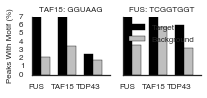

In [339]:
num_rows = 1
num_cols = 2
width=.35
ind = np.arange(len(ggtaag))

ggtaag = motif_counts.xs("GGTAAG", level="motif").xs("all", level="region").percent_in_peak.unstack()
with dataviz.Figure(os.path.join(img_dir, "motif_frequencies.svg"), figsize=(1.5 * num_cols,1.5*num_rows)) as fig:
    gs = gridspec.GridSpec(num_rows, num_cols)

    ax = fig.add_subplot(gs[0,0])

    ax.bar(ind, ggtaag.real, width, color=target_color, label="Target")
    ax.bar(ind + width, ggtaag.random, width, color=non_target_color, label="Background")
    
    ax.set_xticks(ind + (width / 2))
    ax.set_xticklabels([rbp_names[name] for name in ggtaag.index], fontsize=10)
    ax.set_title("TAF15: GGUAAG", fontsize=8)
    ax.set_ylabel("Peaks With Motif (%)", fontsize=8)

    ax.set_ylim(0,7)
    #ax.legend(loc=0, fontsize=8)
    sns.despine(ax=ax)
    
    [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(8) for tick in ax.get_yticklabels()]
    

    ax = fig.add_subplot(gs[0,1])

    ax.bar(ind, tcggtggt.real, width, color=target_color, label="Target")
    ax.bar(ind + width, tcggtggt.random, width, color=non_target_color, label="Background")
    
    ax.set_xticks(ind + (width / 2))
    ax.set_xticklabels([rbp_names[name] for name in ggtaag.index], fontsize=10)
    ax.set_title("FUS: TCGGTGGT", fontsize=8)
    #ax.set_ylabel("% of Peaks With Motif", fontsize=8)

    ax.set_ylim(0,7)
    ax.set_yticklabels([])
    ax.legend(loc=0, fontsize=8)
    sns.despine(ax=ax)
    
    [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(8) for tick in ax.get_yticklabels()]


#re-do long intron analysis 

In [340]:
genomic_features = get_genomic_regions.GenomicFeatures("mm9")
genomic_regions = genomic_features.get_genomic_regions()

foo


In [341]:
fus_down_tdp43_down = signifcant_downregulated.ix['fus', 'Straitum'].index & signifcant_downregulated.ix['tdp43', 'Straitum'].index
fus_down_tdp43_up = signifcant_downregulated.ix['fus', 'Straitum'].index & signifcant_upregulated.ix['tdp43', 'Straitum'].index
fus_up_tdp43_down = signifcant_upregulated.ix['fus', 'Straitum'].index & signifcant_downregulated.ix['tdp43', 'Straitum'].index
fus_up_tdp43_up = signifcant_upregulated.ix['fus', 'Straitum'].index & signifcant_upregulated.ix['tdp43', 'Straitum'].index

In [342]:
all_intron_information = pd.concat({"fus_down_tdp43_down_introns": genomic_regions["introns"].filter(lambda x: x.name in fus_down_tdp43_down).saveas().to_dataframe(),
          "fus_down_tdp43_up_introns": genomic_regions["introns"].filter(lambda x: x.name in fus_down_tdp43_up).saveas().to_dataframe(),
          "fus_up_tdp43_down_introns": genomic_regions["introns"].filter(lambda x: x.name in fus_up_tdp43_down).saveas().to_dataframe(),
          "fus_up_tdp43_up_introns": genomic_regions["introns"].filter(lambda x: x.name in fus_up_tdp43_up).saveas().to_dataframe(),},
                                  names=['condition', 'intron_id'])

all_intron_information['intron_length'] = all_intron_information.end - all_intron_information.start 

In [343]:
all_intron_information.groupby(level=0).mean()

start           end  score  intron_length
condition                                                                    
fus_down_tdp43_down_introns  5.250397e+07  5.252432e+07      0   20358.096280
fus_down_tdp43_up_introns    4.593728e+07  4.594176e+07      0    4480.642857
fus_up_tdp43_down_introns    1.266688e+08  1.266883e+08      0   19540.000000
fus_up_tdp43_up_introns      9.345884e+07  9.346288e+07      0    4036.226415

In [344]:
all_intron_information.groupby(level=0).median()

start          end  score  intron_length
condition                                                                  
fus_down_tdp43_down_introns   40979254.0   41041389.0      0         2895.0
fus_down_tdp43_up_introns     43946243.5   43947078.5      0          430.5
fus_up_tdp43_down_introns    126668797.0  126688337.0      0        19540.0
fus_up_tdp43_up_introns       84489588.0   84493497.0      0         1869.0

In [ ]:
all_intron_information = pd.concat({("fus", "down"): genomic_regions["introns"].filter(lambda x: x.name in signifcant_downregulated.ix['fus', 'Straitum'].index).saveas().to_dataframe(),
                                    ("tdp43", "down"): genomic_regions["introns"].filter(lambda x: x.name in signifcant_downregulated.ix['tdp43', 'Straitum'].index).saveas().to_dataframe(),
                                    ("taf15", "down"): genomic_regions["introns"].filter(lambda x: x.name in signifcant_downregulated.ix['taf15', 'Straitum'].index).saveas().to_dataframe(),
                                    ("fus", "up"): genomic_regions["introns"].filter(lambda x: x.name in signifcant_upregulated.ix['fus', 'Straitum'].index ).saveas().to_dataframe(),
                                    ("tdp43", "up"): genomic_regions["introns"].filter(lambda x: x.name in signifcant_upregulated.ix['tdp43', 'Straitum'].index ).saveas().to_dataframe(),
                                    ("taf15", "up"): genomic_regions["introns"].filter(lambda x: x.name in signifcant_upregulated.ix['taf15', 'Straitum'].index ).saveas().to_dataframe(),
                                    },
                                   names=['condition', 'intron_id'])

all_intron_information['intron_length'] = all_intron_information.end - all_intron_information.start 

In [384]:
all_intron_information['rbp'] = all_intron_information.index.get_level_values(0)
all_intron_information['direction'] = all_intron_information.index.get_level_values(1)

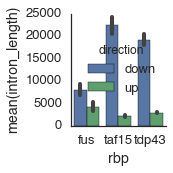

In [385]:
num_rows = 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "intron_length.svg"), figsize=(2.5 * num_cols, 2.5 * num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.barplot(y="intron_length", x="rbp", hue="direction", data=all_intron_information, ax=ax)
    sns.despine(ax=ax)

In [386]:
all_intron_information.intron_length.groupby(level=(0,1)).mean().unstack()

intron_id          down           up
condition                           
fus         8068.540355  4118.492823
taf15      22390.448508  2163.390863
tdp43      19235.374766  2899.254628

In [387]:
pd.DataFrame(all_intron_information.groupby(level=0).mean().intron_length)

intron_length
condition               
fus          7646.474949
taf15       18853.967162
tdp43        9189.703998

#compare list of regulated genes in previous dataset to current dataset

In [350]:
fus_regulated_genes = pd.read_excel("/nas3/gpratt/Dropbox/TAF15/Data/mouse_integration/fold_changes.xlsx", "Sheet1")
fus_downregulated_genes = fus_regulated_genes[fus_regulated_genes.localZ  <= -1.962]
fus_upregulated_genes = fus_regulated_genes[fus_regulated_genes.localZ  >= 1.962]

In [351]:
tdp43_upregulated_genes = pd.read_excel("/nas3/gpratt/Dropbox/TAF15/Data/mouse_integration/Suppl_Table_1.xlsx", "up-regulated")
tdp43_downregulated_genes = pd.read_excel("/nas3/gpratt/Dropbox/TAF15/Data/mouse_integration/Suppl_Table_1.xlsx", "down-regulated")


In [352]:
len(tdp43_upregulated_genes), len(tdp43_downregulated_genes)

(296, 200)

In [353]:
len(set(tdp43_downregulated_genes['gene symbol']) & set(fus_downregulated_genes['Unnamed: 5']))

25

This is what I ended up using, table s2 from FUS/TLS 

In [354]:
bar = pd.read_excel("/nas3/gpratt/Dropbox/TAF15/Data/mouse_integration/table_s2_updated.xlsx", "Sheet2")

In [355]:
codownregulated = bar[bar['Z score.1'] <= -1.962].copy()

In [356]:
len(codownregulated)

44

In [357]:
gene_ids = []
for gene_symbol in codownregulated['Gene Symbol']:
    try:
        gene_ids.append(name_to_gene_id_lower[gene_symbol.lower()])
    except:
        gene_ids.append(np.nan)
        
codownregulated['gene_id'] = gene_ids

In [358]:
codownregulated = codownregulated.dropna(subset=["gene_id"])

In [359]:
co_downregulated = signifcant_downregulated.ix['fus', 'Straitum'].index & signifcant_downregulated.ix['tdp43', 'Straitum'].index


In [360]:
len(codownregulated)

41

In [361]:
codownregulated[codownregulated.gene_id.isin(co_downregulated & set(codownregulated.gene_id))]

Gene Symbol                                            Protein  \
1        Kcnip4           Potassium channel interacting protein 4.   
2         Smyd3                   SET and MYND domain containing 3   
6         Csmd1  Mus musculus adult male hypothalamus cDNA, RIK...   
8        Nkain2     T-cell lymphoma breakpoint associated target 1   
16        Unc80                      MKIAA1843 protein (Fragment).   
18        Unc80           Uncharacterized protein C2orf21 homolog.   
46        Park2                                             parkin   
54        Lrp1b  Mus musculus low density lipoprotein receptor ...   
142      Trim72                     tripartite motif-containing 72   

    Refseq/mRNA identifier  Total  in 5' UTR  in introns  in exons  in 3' UTR  \
1                 DQ148504    818          0         818         0          0   
2                 AK087728    219          0         218         0          1   
6                 AK048698   1056          5        1051         0          3   
8             NM_001013411    382          1         381         0          0   
16                AK173273     50          3          39         1          7   
18                AK043914     26          0          21         3          2   
46               NM_016694    160          0         160         0          0   
54                AK035795    819         23         796         0         10   
142           NM_001079932      0          0           0         0          0   

     RPKM in FUS/TLS KD  RPKM in control          ...            in 5' UTR.1  \
1                 2.036            8.522          ...                      0   
2                 1.692            5.718          ...                      0   
6                 3.884            9.360          ...                      0   
8                 7.049           14.143          ...                      0   
16               15.373           25.553          ...                      0   
18                7.617           13.382          ...                      0   
46                0.633            1.909          ...                      0   
54                2.861            5.090          ...                      1   
142               0.167            0.522          ...                      0   

     in introns.1  in exons.1  in 3' UTR.1  RPKM in TDP-43 KD  \
1             172           0            0              3.560   
2              53           0            0              3.050   
6             261           0            1              2.920   
8             103           1            0              2.478   
16              5           0            0             14.960   
18             11           0            0              6.230   
46             66           0            0              0.485   
54            141           0            0              2.015   
142             0           0            0              0.226   

     RPKM in control.1  Ratio KD/control.1  Z score.1     old_symbol  \
1                8.522            0.417742     -3.645            NaN   
2                5.718            0.533403     -2.511            NaN   
6                9.360            0.311966     -4.826            NaN   
8               14.143            0.175210     -8.086          tcba1   
16              25.553            0.585450     -2.676       BC042720   
18              13.382            0.465551     -3.520  C030018G13Rik   
46               1.909            0.254060     -3.479            NaN   
54               5.090            0.395874     -3.449            NaN   
142              0.522            0.432950     -1.992            NaN   

                   gene_id  
1     ENSMUSG00000029088.8  
2     ENSMUSG00000055067.8  
6     ENSMUSG00000060924.7  
8     ENSMUSG00000069670.1  
16    ENSMUSG00000055567.8  
18    ENSMUSG00000055567.8  
46    ENSMUSG00000023826.7  
54   ENSMUSG00000049252.10  
142   ENSMUSG00000042828.6  

[9 rows x 23 columns]

#genes not found and replaced by hand
1. AK013627 -- doesn't exist
2. AK020190 -- doesn't exist
3. BC042720 -- Unc80
4. C030018G13Rik -- Unc80
5. mKIAA1568 -- Robo2
6. AK161480 -- doesn't exist
7. Rim -- Rims1 
8. AK173072 -- Thsd7a 
9. AK157795 -- B130046B21Rik
10. AK083195 -- A330076H08Rik
11. AK133324 -- Thsd7a 

<matplotlib_venn._common.VennDiagram instance at 0x2aabb4efa710>

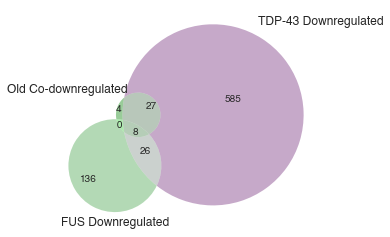

In [362]:
venn3([set(codownregulated.gene_id), 
       set(signifcant_downregulated.ix['tdp43', 'Straitum'].index), 
       set(signifcant_downregulated.ix['fus', 'Straitum'].index)],
      set_labels=['Old Co-downregulated', 'TDP-43 Downregulated', 'FUS Downregulated'],
      set_colors= (['g', rbp_colors['tdp43'], rbp_colors['fus']]),
     )

In [363]:
print len(set(codownregulated.gene_id) & saet(signifcant_downregulated.ix['taf15', 'Straitum'].index))
print len(set(codownregulated.gene_id) & set())
print len(set(codownregulated.gene_id) & set())

NameError: name 'saet' is not defined

#Do motif in regulated Gene analysis

In [ ]:
def annotatePeaks_stranded(peaks, motif, species="hg19", hist=10, size=1000):
    try:
        with open("tmp.txt", 'w') as out:
            subprocess.call(["annotatePeaks.pl",
                             peaks,
                             species,
                             "-m", motif,
                             "-size", "given",
                             "-noann"], shell=False, stdout=out)
    except OSError:
        print "Homer not installed, ignoring motif generation, install homer for this to work"  
        raise   
    print peaks, motif
    annotation = pd.read_table("tmp.txt", index_col=0)
    annotation['stranded_peaks'] = annotation.apply(only_stranded_motifs, axis=1)
    return annotation

def only_stranded_motifs(row):
    motifs = row[-1]
    try:
        true_peaks = "),".join([motif for motif in motifs.split("),") if row.Strand in motif])
        if len(true_peaks) == 0:
            return np.nan
        
        return true_peaks
    except AttributeError:
        return motifs
    
def num_motifs(motifs):
    try:
        true_peaks = [motif for motif in motifs.split("),")]
        return len(true_peaks)
    except AttributeError:
        return 0

In [ ]:
filtered_regions = defaultdict(dict)
for region in genomic_regions:
    filtered_regions[region]["fus_up"] = genomic_regions[region].filter(lambda x: x.name in signifcant_upregulated.ix['taf15', 'Straitum'].index).saveas("fus_up_{}.bed".format(region))
    filtered_regions[region]["taf15_up"] = genomic_regions[region].filter(lambda x: x.name in signifcant_upregulated.ix['fus', 'Straitum'].index).saveas("taf15_up_{}.bed".format(region))
    filtered_regions[region]["tdp43_up"] = genomic_regions[region].filter(lambda x: x.name in signifcant_upregulated.ix['tdp43', 'Straitum'].index).saveas("tdp43_up_{}.bed".format(region))
    filtered_regions[region]["fus_down"] = genomic_regions[region].filter(lambda x: x.name in signifcant_downregulated.ix['taf15', 'Straitum'].index).saveas("fus_down_{}.bed".format(region))
    filtered_regions[region]["taf15_down"] = genomic_regions[region].filter(lambda x: x.name in signifcant_downregulated.ix['fus', 'Straitum'].index).saveas("taf15_down_{}.bed".format(region))
    filtered_regions[region]["tdp43_down"] = genomic_regions[region].filter(lambda x: x.name in signifcant_downregulated.ix['tdp43', 'Straitum'].index).saveas("tdp43_down_{}.bed".format(region))

In [ ]:
def get_motifs_in_regions(regions, motif):
    motifs_in_regions = defaultdict(dict)
    for region in regions:
        for condition in regions[region]:
            motifs_in_regions[region][condition] = annotatePeaks_stranded(filtered_regions[region][condition].fn, motif, species="mm9")
            motifs_in_regions[region][condition]['num_motifs'] = motifs_in_regions[region][condition].stranded_peaks.apply(num_motifs)
            motifs_in_regions[region][condition]['gene_id'] = motifs_in_regions[region][condition].index.map(lambda x: x.split("-")[0])

    return motifs_in_regions

motifs_in_regions = get_motifs_in_regions(filtered_regions, "gguag.motif")
fus_motifs_in_regions = get_motifs_in_regions(filtered_regions, "gugg.motif")
taf15_long_motifs_in_regions = get_motifs_in_regions(filtered_regions, "/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/all/homerResults/motif2.motif")

In [ ]:
regions_name_dict, foo = CLIP_analysis.regions_generator()
regions_name_dict['exons'] = 'Exon'
regions_name_dict['proxintron'] = 'Proximal Intron'
regions_name_dict['distintron'] = 'Distal Intron'
regions_name_dict['genes'] = 'Gene'
regions_name_dict['introns'] = 'Intron'

In [ ]:
taf15_down = taf15_long_motifs_in_regions['genes']['taf15_down']
print len(taf15_down[taf15_down.num_motifs != 0]) /  (len(taf15_down) * 1.0),

taf15_down = motifs_in_regions['genes']['taf15_down']
print len(taf15_down[taf15_down.num_motifs != 0]) /  (len(taf15_down) * 1.0),

In [ ]:
foo = motifs_in_regions['genes']["fus_up"].groupby("gene_id").num_motifs.sum() - motifs_in_regions['introns']["fus_up"].groupby("gene_id").num_motifs.sum()

In [ ]:
num_rows = 8
num_cols = 2
count = 0
with dataviz.Figure(os.path.join(img_dir, "taf15_motif_frequency_bar.svg"), figsize=(num_cols * 4,num_rows * 4)) as fig:
    for region in motifs_in_regions:
        count += 1
        ax = fig.add_subplot(num_rows, num_cols, count)
        fus_up =  motifs_in_regions[region]["fus_up"].groupby("gene_id").sum()
        taf15_up  =  motifs_in_regions[region]["taf15_up"].groupby("gene_id").sum()
        tdp43_up =  motifs_in_regions[region]["tdp43_up"].groupby("gene_id").sum()
        fus_down =  motifs_in_regions[region]["fus_down"].groupby("gene_id").sum()
        taf15_down =  motifs_in_regions[region]["taf15_down"].groupby("gene_id").sum()
        tdp43_down  =  motifs_in_regions[region]["tdp43_down"].groupby("gene_id").sum()
        sns.barplot(["fus_up", "fus_down", "taf15_up", "taf15_down", "tdp43_up", "tdp43_down"], 
                    [len(fus_up[fus_up.num_motifs != 0]) /  (len(fus_up) * 1.0),
                     len(fus_down[fus_down.num_motifs != 0]) /  (len(fus_down) * 1.0),
                     len(taf15_up[taf15_up.num_motifs != 0]) /  (len(taf15_up) * 1.0),
                     len(taf15_down[taf15_down.num_motifs != 0]) /  (len(taf15_down) * 1.0),
                     len(tdp43_up[tdp43_up.num_motifs != 0]) /  (len(tdp43_up) * 1.0),
                     len(tdp43_down[tdp43_down.num_motifs != 0]) /  (len(tdp43_down) * 1.0),
                    ],
                   ax=ax)
        ax.set_ylim(0,1)
        sns.despine(ax=ax)
        [tick.set_rotation(90) for tick in ax.get_xticklabels()]

        ax.set_title("Fraction of {}s\nwith TAF15 motif".format(regions_name_dict[region]))

        count += 1
        ax = fig.add_subplot(num_rows, num_cols, count)
        dataviz.plot_cdf(fus_up.num_motifs, label="fus up", ax=ax, color=rbp_colors['fus'])
        dataviz.plot_cdf(taf15_up.num_motifs, label="taf15 up", ax=ax, color=rbp_colors['taf15'])
        dataviz.plot_cdf(tdp43_up.num_motifs, label="tdp43 up", ax=ax, color=rbp_colors['tdp43'])
        dataviz.plot_cdf(fus_down.num_motifs, label="fus down", ax=ax, color=rbp_colors['fus'], linestyle="--")
        dataviz.plot_cdf(taf15_down.num_motifs, label="taf15 down", ax=ax, color=rbp_colors['taf15'], linestyle="--")
        dataviz.plot_cdf(tdp43_down.num_motifs, label="tdp43 down", ax=ax, color=rbp_colors['tdp43'], linestyle="--")

        ax.legend()
        ax.set_xlabel("Number of Motfs in {}".format(region))
        ax.set_ylabel("Cumulative Fraction")
        ax.set_title("CDF of Number of Motifs in\n{}s of Differentally Stabalized Genes".format(regions_name_dict[region]))
        sns.despine(ax=ax)

In [ ]:
num_rows = 8
num_cols = 2
count = 0
with dataviz.Figure(os.path.join(img_dir, "taf15_motif_frequency_mouse_regulation.svg"), figsize=(num_cols * 4,num_rows * 4)) as fig:
    for region in ['genes', 'three_prime_utrs']:
        count += 1
        ax = fig.add_subplot(num_rows, num_cols, count)
        fus_up =  motifs_in_regions[region]["fus_up"].groupby("gene_id").sum()
        taf15_up  =  motifs_in_regions[region]["taf15_up"].groupby("gene_id").sum()
        tdp43_up =  motifs_in_regions[region]["tdp43_up"].groupby("gene_id").sum()
        fus_down =  motifs_in_regions[region]["fus_down"].groupby("gene_id").sum()
        taf15_down =  motifs_in_regions[region]["taf15_down"].groupby("gene_id").sum()
        tdp43_down  =  motifs_in_regions[region]["tdp43_down"].groupby("gene_id").sum()

        sns.barplot(["FUS Up", "FUS Down", "TAF15 Up", "TAF15 Down", 
                     #"tdp43_up", "tdp43_down"
                    ], 
                    [len(fus_up[fus_up.num_motifs != 0]) /  (len(fus_up) * 1.0),
                     len(fus_down[fus_down.num_motifs != 0]) /  (len(fus_down) * 1.0),
                     len(taf15_up[taf15_up.num_motifs != 0]) /  (len(taf15_up) * 1.0),
                     len(taf15_down[taf15_down.num_motifs != 0]) /  (len(taf15_down) * 1.0),
                     #len(tdp43_up[tdp43_up.num_motifs != 0]) /  (len(tdp43_up) * 1.0),
                     #len(tdp43_down[tdp43_down.num_motifs != 0]) /  (len(tdp43_down) * 1.0),
                    ],
                   ax=ax)
        ax.set_ylim(0,1)
        sns.despine(ax=ax)
        [tick.set_rotation(90) for tick in ax.get_xticklabels()]

        ax.set_title("Fraction of {}s\nwith TAF15 motif".format(regions_name_dict[region]))

#         count += 1
#         ax = fig.add_subplot(num_rows, num_cols, count)
#         dataviz.plot_cdf(fus_up.num_motifs, label="fus up", ax=ax, color=rbp_colors['fus'])
#         dataviz.plot_cdf(taf15_up.num_motifs, label="taf15 up", ax=ax, color=rbp_colors['taf15'])
#         dataviz.plot_cdf(tdp43_up.num_motifs, label="tdp43 up", ax=ax, color=rbp_colors['tdp43'])
#         dataviz.plot_cdf(fus_down.num_motifs, label="fus down", ax=ax, color=rbp_colors['fus'], linestyle="--")
#         dataviz.plot_cdf(taf15_down.num_motifs, label="taf15 down", ax=ax, color=rbp_colors['taf15'], linestyle="--")
#         dataviz.plot_cdf(tdp43_down.num_motifs, label="tdp43 down", ax=ax, color=rbp_colors['tdp43'], linestyle="--")

#         ax.legend()
#         ax.set_xlabel("Number of Motfs in {}".format(region))
#         ax.set_ylabel("Cumulative Fraction")
#         ax.set_title("CDF of Number of Motifs in\n{} of Differentally Stabalized Genes".format(region))
#         sns.despine(ax=ax)

In [ ]:
num_rows = 8
num_cols = 2
count = 0
with dataviz.Figure(os.path.join(img_dir, "taf15_motif_frequency_bar.svg"), figsize=(num_cols * 4,num_rows * 4)) as fig:
    for region in ['genes', 'three_prime_utrs', 'introns']:
        count += 1
        ax = fig.add_subplot(num_rows, num_cols, count)
        fus_up =  motifs_in_regions[region]["fus_up"].groupby("gene_id").sum()
        taf15_up  =  motifs_in_regions[region]["taf15_up"].groupby("gene_id").sum()
        tdp43_up =  motifs_in_regions[region]["tdp43_up"].groupby("gene_id").sum()
        fus_down =  motifs_in_regions[region]["fus_down"].groupby("gene_id").sum()
        taf15_down =  motifs_in_regions[region]["taf15_down"].groupby("gene_id").sum()
        tdp43_down  =  motifs_in_regions[region]["tdp43_down"].groupby("gene_id").sum()
        sns.barplot(["fus_up", "fus_down", "taf15_up", "taf15_down", "tdp43_up", "tdp43_down"], 
                    [len(fus_up[fus_up.num_motifs != 0]) /  (len(fus_up) * 1.0),
                     len(fus_down[fus_down.num_motifs != 0]) /  (len(fus_down) * 1.0),
                     len(taf15_up[taf15_up.num_motifs != 0]) /  (len(taf15_up) * 1.0),
                     len(taf15_down[taf15_down.num_motifs != 0]) /  (len(taf15_down) * 1.0),
                     len(tdp43_up[tdp43_up.num_motifs != 0]) /  (len(tdp43_up) * 1.0),
                     len(tdp43_down[tdp43_down.num_motifs != 0]) /  (len(tdp43_down) * 1.0),
                    ],
                   ax=ax)
        ax.set_ylim(0,1)
        sns.despine(ax=ax)
        [tick.set_rotation(90) for tick in ax.get_xticklabels()]

        ax.set_title("Fraction of {}s\nwith TAF15 motif".format(regions_name_dict[region]))

        count += 1
        ax = fig.add_subplot(num_rows, num_cols, count)
        dataviz.plot_cdf(fus_up.num_motifs, label="fus up", ax=ax, color=rbp_colors['fus'])
        dataviz.plot_cdf(taf15_up.num_motifs, label="taf15 up", ax=ax, color=rbp_colors['taf15'])
        dataviz.plot_cdf(tdp43_up.num_motifs, label="tdp43 up", ax=ax, color=rbp_colors['tdp43'])
        dataviz.plot_cdf(fus_down.num_motifs, label="fus down", ax=ax, color=rbp_colors['fus'], linestyle="--")
        dataviz.plot_cdf(taf15_down.num_motifs, label="taf15 down", ax=ax, color=rbp_colors['taf15'], linestyle="--")
        dataviz.plot_cdf(tdp43_down.num_motifs, label="tdp43 down", ax=ax, color=rbp_colors['tdp43'], linestyle="--")

        ax.legend()
        ax.set_xlabel("Number of Motfs in {}".format(region))
        ax.set_ylabel("Cumulative Fraction")
        ax.set_title("CDF of Number of Motifs in\n{}s of Differentally Expressed Genes".format(regions_name_dict[region]))
        sns.despine(ax=ax)

In [ ]:
num_rows = 8
num_cols = 2
count = 0
with dataviz.Figure(os.path.join(img_dir, "fus_motif_frequency_bar.svg"), figsize=(num_cols * 4,num_rows * 4)) as fig:
    for region in fus_motifs_in_regions:
        count += 1
        ax = fig.add_subplot(num_rows, num_cols, count)
        fus_up =  fus_motifs_in_regions[region]["fus_up"].groupby("gene_id").sum()
        taf15_up  =  fus_motifs_in_regions[region]["taf15_up"].groupby("gene_id").sum()
        tdp43_up =  fus_motifs_in_regions[region]["tdp43_up"].groupby("gene_id").sum()
        fus_down =  fus_motifs_in_regions[region]["fus_down"].groupby("gene_id").sum()
        taf15_down =  fus_motifs_in_regions[region]["taf15_down"].groupby("gene_id").sum()
        tdp43_down  =  fus_motifs_in_regions[region]["tdp43_down"].groupby("gene_id").sum()

        sns.barplot(["fus_up", "fus_down", "taf15_up", "taf15_down", "tdp43_up", "tdp43_down"], 
                    [len(fus_up[fus_up.num_motifs != 0]) /  (len(fus_up) * 1.0),
                     len(fus_down[fus_down.num_motifs != 0]) /  (len(fus_down) * 1.0),
                     len(taf15_up[taf15_up.num_motifs != 0]) /  (len(taf15_up) * 1.0),
                     len(taf15_down[taf15_down.num_motifs != 0]) /  (len(taf15_down) * 1.0),
                     len(tdp43_up[tdp43_up.num_motifs != 0]) /  (len(tdp43_up) * 1.0),
                     len(tdp43_down[tdp43_down.num_motifs != 0]) /  (len(tdp43_down) * 1.0),
                    ],
                   ax=ax)
        sns.despine(ax=ax)
        ax.set_ylim(0,1)

        [tick.set_rotation(90) for tick in ax.get_xticklabels()]

        ax.set_title("Fraction of {}s\nwith FUS motif".format(regions_name_dict[region]))

        count += 1
        ax = fig.add_subplot(num_rows, num_cols, count)
        dataviz.plot_cdf(fus_up.num_motifs, label="fus up", ax=ax, color=rbp_colors['fus'])
        dataviz.plot_cdf(taf15_up.num_motifs, label="taf15 up", ax=ax, color=rbp_colors['taf15'])
        dataviz.plot_cdf(tdp43_up.num_motifs, label="tdp43 up", ax=ax, color=rbp_colors['tdp43'])
        dataviz.plot_cdf(fus_down.num_motifs, label="fus down", ax=ax, color=rbp_colors['fus'], linestyle="--")
        dataviz.plot_cdf(taf15_down.num_motifs, label="taf15 down", ax=ax, color=rbp_colors['taf15'], linestyle="--")
        dataviz.plot_cdf(tdp43_down.num_motifs, label="tdp43 down", ax=ax, color=rbp_colors['tdp43'], linestyle="--")


        ax.legend()
        ax.set_xlabel("Number of Motfs in {}".format(region))
        ax.set_ylabel("Cumulative Fraction")
        ax.set_title("CDF of Number of Motifs in\n{}s of Differentally Stabalized Genes".format(regions_name_dict[region]))
        sns.despine(ax=ax)

In [ ]:
num_rows = 8
num_cols = 2
count = 0
with dataviz.Figure(os.path.join(img_dir, "fus_motif_frequency_mouse_regulation.svg"), figsize=(num_cols * 4,num_rows * 4)) as fig:
    for region in ['genes', 'three_prime_utrs']:
        count += 1
        ax = fig.add_subplot(num_rows, num_cols, count)
        fus_up =  fus_motifs_in_regions[region]["fus_up"].groupby("gene_id").sum()
        taf15_up  =  fus_motifs_in_regions[region]["taf15_up"].groupby("gene_id").sum()
        tdp43_up =  fus_motifs_in_regions[region]["tdp43_up"].groupby("gene_id").sum()
        fus_down =  fus_motifs_in_regions[region]["fus_down"].groupby("gene_id").sum()
        taf15_down =  fus_motifs_in_regions[region]["taf15_down"].groupby("gene_id").sum()
        tdp43_down  =  fus_motifs_in_regions[region]["tdp43_down"].groupby("gene_id").sum()

        sns.barplot(["FUS Up", "FUS Down", "TAF15 Up", "TAF15 Down", 
                     #"tdp43_up", "tdp43_down"
                    ], 
                    [len(fus_up[fus_up.num_motifs != 0]) /  (len(fus_up) * 1.0),
                     len(fus_down[fus_down.num_motifs != 0]) /  (len(fus_down) * 1.0),
                     len(taf15_up[taf15_up.num_motifs != 0]) /  (len(taf15_up) * 1.0),
                     len(taf15_down[taf15_down.num_motifs != 0]) /  (len(taf15_down) * 1.0),
                     #len(tdp43_up[tdp43_up.num_motifs != 0]) /  (len(tdp43_up) * 1.0),
                     #len(tdp43_down[tdp43_down.num_motifs != 0]) /  (len(tdp43_down) * 1.0),
                    ],
                   ax=ax)
        ax.set_ylim(0,1)
        sns.despine(ax=ax)
        [tick.set_rotation(90) for tick in ax.get_xticklabels()]

        ax.set_title("Fraction of {}s\nwith FUS motif".format(regions_name_dict[region]))

#         count += 1
#         ax = fig.add_subplot(num_rows, num_cols, count)
#         dataviz.plot_cdf(fus_up.num_motifs, label="fus up", ax=ax, color=rbp_colors['fus'])
#         dataviz.plot_cdf(taf15_up.num_motifs, label="taf15 up", ax=ax, color=rbp_colors['taf15'])
#         dataviz.plot_cdf(tdp43_up.num_motifs, label="tdp43 up", ax=ax, color=rbp_colors['tdp43'])
#         dataviz.plot_cdf(fus_down.num_motifs, label="fus down", ax=ax, color=rbp_colors['fus'], linestyle="--")
#         dataviz.plot_cdf(taf15_down.num_motifs, label="taf15 down", ax=ax, color=rbp_colors['taf15'], linestyle="--")
#         dataviz.plot_cdf(tdp43_down.num_motifs, label="tdp43 down", ax=ax, color=rbp_colors['tdp43'], linestyle="--")

#         ax.legend()
#         ax.set_xlabel("Number of Motfs in {}".format(region))
#         ax.set_ylabel("Cumulative Fraction")
#         ax.set_title("CDF of Number of Motifs in\n{} of Differentally Stabalized Genes".format(region))
#         sns.despine(ax=ax)

In [ ]:
num_rows = 8
num_cols = 2
count = 0
with dataviz.Figure(os.path.join(img_dir, "fus_motif_frequency_bar.svg"), figsize=(num_cols * 4,num_rows * 4)) as fig:
    for region in ['genes', 'three_prime_utrs', 'introns']:
        count += 1
        ax = fig.add_subplot(num_rows, num_cols, count)
        fus_up =  fus_motifs_in_regions[region]["fus_up"].groupby("gene_id").sum()
        taf15_up  =  fus_motifs_in_regions[region]["taf15_up"].groupby("gene_id").sum()
        tdp43_up =  fus_motifs_in_regions[region]["tdp43_up"].groupby("gene_id").sum()
        fus_down =  fus_motifs_in_regions[region]["fus_down"].groupby("gene_id").sum()
        taf15_down =  fus_motifs_in_regions[region]["taf15_down"].groupby("gene_id").sum()
        tdp43_down  =  fus_motifs_in_regions[region]["tdp43_down"].groupby("gene_id").sum()

        sns.barplot(["fus_up", "fus_down", "taf15_up", "taf15_down", "tdp43_up", "tdp43_down"], 
                    [len(fus_up[fus_up.num_motifs != 0]) /  (len(fus_up) * 1.0),
                     len(fus_down[fus_down.num_motifs != 0]) /  (len(fus_down) * 1.0),
                     len(taf15_up[taf15_up.num_motifs != 0]) /  (len(taf15_up) * 1.0),
                     len(taf15_down[taf15_down.num_motifs != 0]) /  (len(taf15_down) * 1.0),
                     len(tdp43_up[tdp43_up.num_motifs != 0]) /  (len(tdp43_up) * 1.0),
                     len(tdp43_down[tdp43_down.num_motifs != 0]) /  (len(tdp43_down) * 1.0),
                    ],
                   ax=ax)
        sns.despine(ax=ax)
        ax.set_ylim(0,1)

        [tick.set_rotation(90) for tick in ax.get_xticklabels()]

        ax.set_title("Fraction of {}s\nwith FUS motif".format(regions_name_dict[region]))

        count += 1
        ax = fig.add_subplot(num_rows, num_cols, count)
        dataviz.plot_cdf(fus_up.num_motifs, label="fus up", ax=ax, color=rbp_colors['fus'])
        dataviz.plot_cdf(taf15_up.num_motifs, label="taf15 up", ax=ax, color=rbp_colors['taf15'])
        dataviz.plot_cdf(tdp43_up.num_motifs, label="tdp43 up", ax=ax, color=rbp_colors['tdp43'])
        dataviz.plot_cdf(fus_down.num_motifs, label="fus down", ax=ax, color=rbp_colors['fus'], linestyle="--")
        dataviz.plot_cdf(taf15_down.num_motifs, label="taf15 down", ax=ax, color=rbp_colors['taf15'], linestyle="--")
        dataviz.plot_cdf(tdp43_down.num_motifs, label="tdp43 down", ax=ax, color=rbp_colors['tdp43'], linestyle="--")


        ax.legend()
        ax.set_xlabel("Number of Motfs in {}".format(region))
        ax.set_ylabel("Cumulative Fraction")
        ax.set_title("CDF of Number of Motifs in\n{}s of Differentally Expressed Genes".format(regions_name_dict[region]))
        sns.despine(ax=ax)

In [ ]:
num_rows = 8
num_cols = 2
count = 0
with dataviz.Figure(os.path.join(img_dir, "fus_motif_frequency_bar.svg"), figsize=(num_cols * 4,num_rows * 4)) as fig:
    for region in fus_motifs_in_regions:
        count += 1
        ax = fig.add_subplot(num_rows, num_cols, count)
        fus_up =  taf15_long_motifs_in_regions[region]["fus_up"].groupby("gene_id").sum()
        taf15_up  =  taf15_long_motifs_in_regions[region]["taf15_up"].groupby("gene_id").sum()
        tdp43_up =  taf15_long_motifs_in_regions[region]["tdp43_up"].groupby("gene_id").sum()
        fus_down =  taf15_long_motifs_in_regions[region]["fus_down"].groupby("gene_id").sum()
        taf15_down =  taf15_long_motifs_in_regions[region]["taf15_down"].groupby("gene_id").sum()
        tdp43_down  =  taf15_long_motifs_in_regions[region]["tdp43_down"].groupby("gene_id").sum()
        sns.barplot(["fus_up", "fus_down", "taf15_up", "taf15_down", "tdp43_up", "tdp43_down"], 
                    [len(fus_up[fus_up.num_motifs != 0]) /  (len(fus_up) * 1.0),
                     len(fus_down[fus_down.num_motifs != 0]) /  (len(fus_down) * 1.0),
                     len(taf15_up[taf15_up.num_motifs != 0]) /  (len(taf15_up) * 1.0),
                     len(taf15_down[taf15_down.num_motifs != 0]) /  (len(taf15_down) * 1.0),
                     len(tdp43_up[tdp43_up.num_motifs != 0]) /  (len(tdp43_up) * 1.0),
                     len(tdp43_down[tdp43_down.num_motifs != 0]) /  (len(tdp43_down) * 1.0),
                    ],
                   ax=ax)
        sns.despine(ax=ax)
        ax.set_ylim(0,1)

        [tick.set_rotation(90) for tick in ax.get_xticklabels()]

        ax.set_title("Fraction of {}\nwith TAF15 motif".format(region))

        count += 1
        ax = fig.add_subplot(num_rows, num_cols, count)
        dataviz.plot_cdf(fus_up.num_motifs, label="fus up", ax=ax, color=rbp_colors['fus'])
        dataviz.plot_cdf(taf15_up.num_motifs, label="taf15 up", ax=ax, color=rbp_colors['taf15'])
        dataviz.plot_cdf(tdp43_up.num_motifs, label="tdp43 up", ax=ax, color=rbp_colors['tdp43'])
        dataviz.plot_cdf(fus_down.num_motifs, label="fus down", ax=ax, color=rbp_colors['fus'], linestyle="--")
        dataviz.plot_cdf(taf15_down.num_motifs, label="taf15 down", ax=ax, color=rbp_colors['taf15'], linestyle="--")
        dataviz.plot_cdf(tdp43_down.num_motifs, label="tdp43 down", ax=ax, color=rbp_colors['tdp43'], linestyle="--")

        ax.legend()
        ax.set_xlabel("Number of Motfs in {}".format(region))
        ax.set_ylabel("Cumulative Fraction")
        ax.set_title("CDF of Number of Motifs in\n{} of Differentally Stabalized Genes".format(region))
        sns.despine(ax=ax)

In [ ]:
for region in taf15_long_motifs_in_regions.keys():
    print region, len(taf15_long_motifs_in_regions[region]['taf15_down'].groupby("gene_id").count()['num_motifs'])

In [ ]:
#motifs_in_regions['genes']['taf15_down'].groupby("gene_id").sum()[motifs_in_regions['genes']['taf15_down'].groupby("gene_id").num_motifs.sum() == 0]

In [ ]:
foo = motifs_in_regions['introns']['taf15_down'].groupby("gene_id").sum() - motifs_in_regions['genes']['taf15_down'].groupby("gene_id").sum()

#Binding vs Expression Comparison